# Load packages and define functions

In [1]:
import pandas as pd
import pyam
import numpy as np

import datatoolbox as dt

from pandas_indexing import *

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
import seaborn as sns

ca_colors = ['#95AD28','#2C8090','#F0280E','#F0CF1C','#1478B0','#59C954','#059E73','#945EB0','#383836','#828282','#C2C2C2']
ca_colors = sns.color_palette(ca_colors)
ca_colors

from matplotlib import rcParams
rcParams['font.sans-serif'] = ['Lato']

sns.set_palette(ca_colors)

import data_shepherd as ds
from data_shepherd import utils

import pycountry
from scipy.stats import linregress
from scipy.optimize import curve_fit
from lmfit import Model

pd.set_option("display.precision", 2)

<IPython.core.display.Javascript object>

Remote: (17) new sources and (2) updated sources are available online (see dt.available_remote_data_updates)


In [2]:
def cap_add(tech):
    return f"Capacity Additions|Electricity|{tech}"

def cap(tech):
    return f"Capacity|Electricity|{tech}"

def elec(tech=None):
    if tech is None:
        return "Secondary Energy|Electricity"
    else:
        return f"Secondary Energy|Electricity|{tech}"

def inv(tech=None):
    if tech is None:
        return 'Investment|Energy Supply|Electricity'
    else:
        return f'Investment|Energy Supply|Electricity|{tech}'

def cost(tech):
    return f'Capital Cost|Electricity|{tech}'

In [3]:
def exponential(x,a,b):
    y = a * np.exp(b*x)
    return (y)

def linear(x,a,b):
    y = a*x + b
    return (y)
    
def quadratic(x,a,b,c):
    y = a*(x**2) + b*x + c
    return (y)

# Define regions
We are using 6 major world regions, which are listed below with their names.

In [4]:
regions = ['R5OECD','R5ASIA','R10AFRICA','R10LATIN_AM','R10REF_ECON','R10MIDDLE_EAST','World']
region_names = ['OECD','Asia','Sub-Saharan Africa','Latin America','Eurasia','Middle East and North Africa','World']

We use the REMIND region mapping to determine which ISOS are inside each of these region.  
This is justified as the majority of pathways being used are REMIND pathways.

In [5]:
remind_map = ds.utils.RegionMapping.from_model('R10_REMIND_2.1').iso_to_region
message_map = ds.utils.RegionMapping.from_model('R10_MESSAGE-GLOBIOM_1.2').iso_to_region
witch_map = ds.utils.RegionMapping.from_model('R10_WITCH_5.0').iso_to_region



oecd_isos = list(remind_map.loc[remind_map.isin(['R10EUROPE','R10NORTH_AM','R10PAC_OECD','R10ROWO'])].index)
asia_isos = list(remind_map.loc[remind_map.isin(['R10CHINA+','R10INDIA+','R10REST_ASIA'])].index)
africa_isos = list(remind_map.loc[remind_map.isin(['R10AFRICA'])].index)
latam_isos = list(remind_map.loc[remind_map.isin(['R10LATIN_AM'])].index)
ref_isos = list(remind_map.loc[remind_map.isin(['R10REF_ECON'])].index)
mideast_isos = list(remind_map.loc[remind_map.isin(['R10MIDDLE_EAST'])].index)
world_isos = list(remind_map.index)

eu27_isos = ds.utils.RegionMapping.from_model('EU27').iso_to_region.index

region_isos = [oecd_isos,asia_isos,africa_isos,latam_isos,ref_isos,mideast_isos,world_isos]

However, we also check what difference in the region mapping there is between MESSAGE, REMIND and WITCH (the three main models being used overall for the analysis).  
If there were significant regional differences in mapping, this could cause problems

In [6]:
regional_diff = pd.DataFrame(
    columns=['remind_message','remind_witch','message_witch'],
    index=regions[:-1])

regional_diff.index.names=['region']

In [7]:
def iso_to_name(iso):
    if pycountry.countries.get(alpha_3=iso) is None:
        return iso
    else:
        return  pycountry.countries.get(alpha_3=iso).name


In [8]:
def process_region(region, isos):
    m_isos = set([iso_to_name(iso) for iso in message_map.loc[message_map.isin(isos)].index])
    r_isos = set([iso_to_name(iso) for iso in remind_map.loc[remind_map.isin(isos)].index])
    w_isos = set([iso_to_name(iso) for iso in witch_map.loc[witch_map.isin(isos)].index])

    regional_diff.loc[region, 'remind_message'] = dict(zip(
        ['REMIND_unique', 'MESSAGE_unique'],
        [list(r_isos - m_isos), list(m_isos - r_isos)])).items()

    regional_diff.loc[region, 'remind_witch'] = dict(zip(
        ['REMIND_unique', 'WITCH_unique'],
        [list(r_isos - w_isos), list(w_isos - r_isos)])).items()

    regional_diff.loc[region, 'message_witch'] = dict(zip(
        ['MESSAGE_unique', 'WITCH_unique'],
        [list(m_isos - w_isos), list(w_isos - m_isos)])).items()

for region in regional_diff.index[2:]:
    process_region(region, [region])

for region, isos in dict(zip(['R5OECD', 'R5ASIA'], [['R10EUROPE', 'R10NORTH_AM', 'R10PAC_OECD', 'R10ROWO'],
                                                      ['R10CHINA+', 'R10INDIA+', 'R10REST_ASIA']])).items():
    process_region(region, isos)

# Display the updated regional_diff
regional_diff

remind_message  \
region                                                              
R5OECD          ((REMIND_unique, []), (MESSAGE_unique, [Mayott...   
R5ASIA          ((REMIND_unique, [French Southern Territories,...   
R10AFRICA       ((REMIND_unique, [Mayotte, Saint Helena, Ascen...   
R10LATIN_AM     ((REMIND_unique, [Antarctica, Virgin Islands, ...   
R10REF_ECON           ((REMIND_unique, []), (MESSAGE_unique, []))   
R10MIDDLE_EAST  ((REMIND_unique, [Western Sahara]), (MESSAGE_u...   

                                                     remind_witch  \
region                                                              
R5OECD          ((REMIND_unique, [Turkey]), (WITCH_unique, [Ki...   
R5ASIA          ((REMIND_unique, [Kiribati, Nauru, Korea, Demo...   
R10AFRICA       ((REMIND_unique, []), (WITCH_unique, [Bouvet I...   
R10LATIN_AM     ((REMIND_unique, [Bouvet Island]), (WITCH_uniq...   
R10REF_ECON     ((REMIND_unique, []), (WITCH_unique, [Mongolia...   
R10MIDDLE_EAST     ((REMIND_unique, [Sudan]), (WITCH_unique, []))   

                                                    message_witch  
region                                                             
R5OECD          ((MESSAGE_unique, [Virgin Islands, British, Sa...  
R5ASIA          ((MESSAGE_unique, [Kiribati, Nauru, Korea, Dem...  
R10AFRICA       ((MESSAGE_unique, [Western Sahara]), (WITCH_un...  
R10LATIN_AM     ((MESSAGE_unique, []), (WITCH_unique, [Antarct...  
R10REF_ECON     ((MESSAGE_unique, []), (WITCH_unique, [Mongoli...  
R10MIDDLE_EAST  ((MESSAGE_unique, [South Sudan, Sudan]), (WITC...

The regional mapping seems to be relatively consistent across the models. The main areas of difference are:
- South Korea. This is in R5ASIA for MESSAGE/REMIND, but R5OECD for WITCH. The same for North Korea
- Turkey. This is in R5OECD for MESSAGE/REMIND, but R10REF_ECON for WITCH
- Small Islands. These are distributed differently across continents in all models - but are unlikely to have a large impact

# Load data
Data is cleaned and processed in `process_data.ipynb`

## 1.5ºC compatible pathway data

In [9]:
ar6_data = pyam.IamDataFrame('../data/processed/ar6_pathway_data.csv')
ar6_data.meta = pd.read_csv('../data/processed/ar6_pathway_meta.csv',
                           index_col=[0,1])

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ../data/processed/ar6_pathway_data.csv


In [10]:
pop_ar6 = ar6_data.filter(variable='Pop**').filter(scenario='SSP2_v9',keep=False).timeseries().reset_index()
pop_ar6.model = [s.split('|')[1] for s in pop_ar6.scenario]
pop_ar6.scenario = [s.split('|')[0][8:] for s in pop_ar6.scenario]
pop_ar6 = pyam.IamDataFrame(pop_ar6)

pop_ar6.aggregate_region(
    'Population',
    'R5OECD',
    ['R10EUROPE','R10PAC_OECD','R10NORTH_AM','R10ROWO'],
    append=True)

pop_ar6.aggregate_region(
    'Population',
    'R5ASIA',
    ['R10CHINA+','R10INDIA+','R10REST_ASIA'],
    append=True)

ar6_data.append(pop_ar6,inplace=True)

## Historical capacity data

In [11]:
cap_hist = pd.read_csv('../data/processed/capacity_historic.csv',
                      index_col=[0,1,2,3])
cap_hist.columns = list(range(2000,2024))

# for now focusing on the 'main' scenario from the IEA, rather than the accelerated
cap_hist = cap_hist.loc[isin(scenario='Main')].droplevel('scenario')
cap_hist


2000    2001    2002  \
region variable                                unit                           
ABW    Capacity|Electricity|Renewables         GW      0.00    0.00    0.00   
       Capacity|Electricity|Renewables|Non-WnS GW      0.00    0.00    0.00   
       Capacity|Electricity|Solar              GW      0.00    0.00    0.00   
       Capacity|Electricity|Wind               GW      0.00    0.00    0.00   
       Capacity|Electricity|WnS                GW      0.00    0.00    0.00   
...                                                     ...     ...     ...   
EU27   Capacity|Electricity|Renewables         GW    134.72  140.40  147.05   
       Capacity|Electricity|Renewables|Non-WnS GW    122.27  123.28  124.11   
       Capacity|Electricity|Solar              GW      0.16    0.26    0.35   
       Capacity|Electricity|Wind               GW     12.29   16.86   22.59   
       Capacity|Electricity|WnS                GW     12.45   17.12   22.94   

                                                       2003    2004    2005  \
region variable                                unit                           
ABW    Capacity|Electricity|Renewables         GW      0.00    0.00    0.00   
       Capacity|Electricity|Renewables|Non-WnS GW      0.00    0.00    0.00   
       Capacity|Electricity|Solar              GW      0.00    0.00    0.00   
       Capacity|Electricity|Wind               GW      0.00    0.00    0.00   
       Capacity|Electricity|WnS                GW      0.00    0.00    0.00   
...                                                     ...     ...     ...   
EU27   Capacity|Electricity|Renewables         GW    154.15  163.43  173.83   
       Capacity|Electricity|Renewables|Non-WnS GW    126.32  128.98  132.84   
       Capacity|Electricity|Solar              GW      0.58    1.28    2.24   
       Capacity|Electricity|Wind               GW     27.25   33.17   38.75   
       Capacity|Electricity|WnS                GW     27.83   34.45   40.99   

                                                       2006    2007    2008  \
region variable                                unit                           
ABW    Capacity|Electricity|Renewables         GW      0.00    0.00    0.00   
       Capacity|Electricity|Renewables|Non-WnS GW      0.00    0.00    0.00   
       Capacity|Electricity|Solar              GW      0.00    0.00    0.00   
       Capacity|Electricity|Wind               GW      0.00    0.00    0.00   
       Capacity|Electricity|WnS                GW      0.00    0.00    0.00   
...                                                     ...     ...     ...   
EU27   Capacity|Electricity|Renewables         GW    183.79  194.29  208.51   
       Capacity|Electricity|Renewables|Non-WnS GW    135.02  135.92  137.99   
       Capacity|Electricity|Solar              GW      3.19    4.96   10.43   
       Capacity|Electricity|Wind               GW     45.58   53.41   60.09   
       Capacity|Electricity|WnS                GW     48.77   58.37   70.52   

                                                       2009  ...    2014  \
region variable                                unit          ...           
ABW    Capacity|Electricity|Renewables         GW      0.03  ...    0.03   
       Capacity|Electricity|Renewables|Non-WnS GW      0.00  ...    0.00   
       Capacity|Electricity|Solar              GW      0.00  ...    0.00   
       Capacity|Electricity|Wind               GW      0.03  ...    0.03   
       Capacity|Electricity|WnS                GW      0.03  ...    0.03   
...                                                     ...  ...     ...   
EU27   Capacity|Electricity|Renewables         GW    229.73  ...  352.04   
       Capacity|Electricity|Renewables|Non-WnS GW    141.88  ...  152.78   
       Capacity|Electricity|Solar              GW     17.01  ...   83.62   
       Capacity|Electricity|Wind               GW     70.84  ...  115.64   
       Capacity|Electricity|WnS                GW     87.85

In [12]:
cap_hist.loc[isin(region='R5OECD',variable=cap('Renewables')),2018:]

2018     2019     2020  \
region variable                        unit                              
R5OECD Capacity|Electricity|Renewables GW    1041.08  1108.73  1192.15   

                                                2021     2022     2023  
region variable                        unit                             
R5OECD Capacity|Electricity|Renewables GW    1285.91  1382.49  1527.51

In [13]:
n=5

(
    cap_hist.loc[isin(region='R5OECD',variable=cap('WnS'))] / 
    cap_hist.loc[isin(region='R5OECD',variable=cap('WnS'))].shift(axis=1,periods=n)
)**(1/n)*100

2000  2001  2002  2003  2004    2005  \
region variable                 unit                                         
R5OECD Capacity|Electricity|WnS GW     NaN   NaN   NaN   NaN   NaN  128.02   

                                        2006    2007    2008    2009  ...  \
region variable                 unit                                  ...   
R5OECD Capacity|Electricity|WnS GW    124.73  123.57  123.89  125.16  ...   

                                        2014    2015    2016    2017   2018  \
region variable                 unit                                          
R5OECD Capacity|Electricity|WnS GW    120.26  118.47  115.59  112.99  112.2   

                                        2019    2020    2021    2022    2023  
region variable                 unit                                          
R5OECD Capacity|Electricity|WnS GW    111.83  111.51  111.59  111.77  112.82  

[1 rows x 24 columns]

## Future capacity forecasts from the IEA

In [14]:
cap_future = pd.read_csv('../data/processed/capacity_iea_forecasts.csv',
                      index_col=[0,1,2,3])
cap_future.columns = list(range(2000,2029))
cap_future = cap_future[list(range(2023,2029))].dropna()
cap_future.head()

2023  \
region scenario    variable                                unit             
ARE    Accelerated Capacity|Electricity|Renewables         GW    7.79e+00   
                   Capacity|Electricity|Renewables|Non-WnS GW    8.11e-01   
                   Capacity|Electricity|Solar              GW    6.98e+00   
                   Capacity|Electricity|Wind               GW    1.50e-05   
                   Capacity|Electricity|WnS                GW    6.98e+00   

                                                                     2024  \
region scenario    variable                                unit             
ARE    Accelerated Capacity|Electricity|Renewables         GW    8.59e+00   
                   Capacity|Electricity|Renewables|Non-WnS GW    1.10e+00   
                   Capacity|Electricity|Solar              GW    7.50e+00   
                   Capacity|Electricity|Wind               GW    1.50e-05   
                   Capacity|Electricity|WnS                GW    7.50e+00   

                                                                     2025  \
region scenario    variable                                unit             
ARE    Accelerated Capacity|Electricity|Renewables         GW    1.00e+01   
                   Capacity|Electricity|Renewables|Non-WnS GW    1.26e+00   
                   Capacity|Electricity|Solar              GW    8.77e+00   
                   Capacity|Electricity|Wind               GW    1.50e-05   
                   Capacity|Electricity|WnS                GW    8.77e+00   

                                                                     2026  \
region scenario    variable                                unit             
ARE    Accelerated Capacity|Electricity|Renewables         GW    1.24e+01   
                   Capacity|Electricity|Renewables|Non-WnS GW    1.26e+00   
                   Capacity|Electricity|Solar              GW    1.11e+01   
                   Capacity|Electricity|Wind               GW    1.50e-05   
                   Capacity|Electricity|WnS                GW    1.11e+01   

                                                                     2027  \
region scenario    variable                                unit             
ARE    Accelerated Capacity|Electricity|Renewables         GW    1.61e+01   
                   Capacity|Electricity|Renewables|Non-WnS GW    1.29e+00   
                   Capacity|Electricity|Solar              GW    1.48e+01   
                   Capacity|Electricity|Wind               GW    1.50e-05   
                   Capacity|Electricity|WnS                GW    1.48e+01   

                                                                     2028  
region scenario    variable                                unit            
ARE    Accelerated Capacity|Electricity|Renewables         GW    1.92e+01  
                   Capacity|Electricity|Renewables|Non-WnS GW    1.29e+00  
                   Capacity|Electricity|Solar              GW    1.79e+01  
                   Capacity|Electricity|Wind               GW    1.50e-05  
                   Capacity|Electricity|WnS                GW    1.79e+01

In [15]:
cap_forecast = cap_future.copy()

for ix in cap_forecast.index[:]:
    ydata = cap_forecast.loc[ix,2023:2028].values
    xdata = list(range(2023,2029))
    
    #Fit model
    model = Model(quadratic)
    params = model.make_params(a=1,b=0.2,c=0)
    # params['A'] = ydata
    result = model.fit(ydata, params, x=xdata)
    
    # Produce future projection + uncertainty. Sigma of 1.35 gives 75% confidence interval,
    # assuming that the data is normally distributed.
    future_years = np.linspace(2023,2030,8)
    future_data = result.eval(x=future_years)

    cap_forecast.loc[ix,future_years] = future_data

cap_forecast.loc[isin(region='World',variable=cap('Renewables'))]

2023.0   2024.0  \
region scenario    variable                        unit                     
World  Accelerated Capacity|Electricity|Renewables GW    3947.94  4584.06   
       Main        Capacity|Electricity|Renewables GW    3893.23  4434.20   

                                                          2025.0   2026.0  \
region scenario    variable                        unit                     
World  Accelerated Capacity|Electricity|Renewables GW    5292.26  6072.53   
       Main        Capacity|Electricity|Renewables GW    5021.38  5654.77   

                                                          2027.0   2028.0  \
region scenario    variable                        unit                     
World  Accelerated Capacity|Electricity|Renewables GW    6924.89  7849.32   
       Main        Capacity|Electricity|Renewables GW    6334.37  7060.18   

                                                          2029.0   2030.0  
region scenario    variable                        unit                    
World  Accelerated Capacity|Electricity|Renewables GW    8845.83  9914.42  
       Main        Capacity|Electricity|Renewables GW    7832.20  8650.44

In [16]:
ix_order = ['region','scenario','variable','unit']

cap_forecast = (
    pd.concat([
        pd.concat([
            assignlevel(cap_hist,scenario='Main').reorder_levels(ix_order),
            assignlevel(cap_hist,scenario='Accelerated').reorder_levels(ix_order)
        ]),
        cap_forecast.loc[:,2024:]
    ],axis=1)
)

## Targets data
We use targets data from Ember: https://ember-climate.org/insights/research/tracking-national-ambition-towards-a-global-tripling-of-renewables/

In [17]:
targets_data = pd.read_excel(
    '../data/raw/ember_targets_v3.xlsx',
    sheet_name='capacity_target_wide',
    index_col=[0,1,2,3,4,5])



In [18]:
cap_targets = pd.DataFrame()

#Aggregate the national targets from Ember to a regional level
for region, isos in dict(zip(
    regions,
    [oecd_isos,asia_isos,africa_isos,latam_isos,ref_isos,mideast_isos])).items():

        regional_renewables = pd.DataFrame(assignlevel(
            targets_data.loc[isin(country_code=isos,target_year=2030),'res_capacity_target'].groupby('target_year').sum(),
            region=region))

        regional_wns = pd.DataFrame(assignlevel(
            targets_data.loc[isin(country_code=isos,target_year=2030),['Wind','Solar']].groupby('target_year').sum().sum(axis=1),
            region=region)).rename(columns={0:'wns_capacity_target'})

        cap_targets = pd.concat([cap_targets,pd.concat([regional_renewables,regional_wns],axis=1)])

cap_targets = pd.concat(
    [
        cap_targets,
        assignlevel(cap_targets.groupby(['target_year']).sum(),region='World')
    ])

cap_targets

res_capacity_target  wns_capacity_target
target_year region                                                  
2030        R5OECD                      2809.44              1540.51
            R5ASIA                      3234.51              2407.05
            R10AFRICA                     30.63                26.03
            R10LATIN_AM                  444.28               145.63
            R10REF_ECON                   62.00                 5.00
            R10MIDDLE_EAST               108.47                97.69
            World                       6689.33              4221.90

The Ember targets have around 93% overall coverage. But this coverage is not uniform across regions - we test what proportion of renewable capacity in each region the countries included in Ember's report account for. Ember's targets cover basically all of the OECD and Asia, but much less in other regions, particularly Africa and the Middle East.  

In [19]:
regional_coverage = pd.DataFrame(
    index=regions,
    columns=['res_capacity_target','wns_capacity_target'])

for region, isos in dict(zip(regions[:],[oecd_isos,asia_isos,africa_isos,latam_isos,ref_isos,mideast_isos,world_isos])).items():
    target_isos = projectlevel(
            targets_data.loc[isin(country_code=isos,target_year=2030),'res_capacity_target'],'country_code').index.unique()
    
    target_rnw_capacity = cap_hist.loc[isin(region=target_isos,variable=cap('Renewables')),2022].sum()
    regional_coverage.loc[region,'res_capacity_target'] = (
        target_rnw_capacity
        /cap_hist.loc[isin(region=region,variable='Capacity|Electricity|Renewables'),2022].squeeze()
        *1e2
    )

    
    target_wns_capacity = cap_hist.loc[isin(region=target_isos,variable=cap('WnS')),2022].sum()
    regional_coverage.loc[region,'wns_capacity_target'] = (
        target_wns_capacity
        /cap_hist.loc[isin(region=region,variable='Capacity|Electricity|WnS'),2022].squeeze()
        *1e2
    )


regional_coverage

res_capacity_target wns_capacity_target
R5OECD                       98.57               99.61
R5ASIA                       96.07               98.11
R10AFRICA                    22.89               70.99
R10LATIN_AM                  81.61               90.32
R10REF_ECON                   60.4               23.26
R10MIDDLE_EAST               43.69               66.64
World                         93.1               97.24

In [20]:
cap_targets_rescaled = cap_targets.droplevel('target_year')/regional_coverage*100
cap_targets_rescaled

res_capacity_target wns_capacity_target
region                                                
R5OECD                     2850.26             1546.46
R5ASIA                     3366.75             2453.46
R10AFRICA                    133.8               36.67
R10LATIN_AM                 544.42              161.24
R10REF_ECON                 102.64               21.49
R10MIDDLE_EAST               248.3              146.59
World                      7185.18             4341.71

## Socio-economic data

In [21]:
gdp_data = dt.findp(variable='GDP|constant_USD',source='WDI_2022').as_pyam()
pop_data = dt.findp(variable='Population',source='WDI_2022').as_pyam()

for region,countries in zip(regions,region_isos):
    gdp_data.aggregate_region(
        'GDP|constant_USD',
        region,
        countries,
        append=True)
    
    pop_data.aggregate_region(
        'Population',
        region,
        countries,
        append=True)

In [22]:
def load_investment(sheet_name):    
    df = pd.read_excel('../data/raw/WorldEnergyInvestment2023_DataFile.xlsx',
                        sheet_name=sheet_name,
                       usecols=range(1,11),
                       skiprows=set(list(range(35)))-set([3])-set(list(range(23,32))),
                       index_col=0)
    
    df = assignlevel(df,region=df.index.name,unit='billion_USD_2022')
    df.index.names = ['variable','region','unit']
    df = df.reorder_levels(['region','variable','unit'])
    return(df)

load_investment('Advanced Economies')

2015    2016  \
region             variable                unit                               
Advanced Economies Power                   billion_USD_2022  377.00  376.00   
                   Generation              billion_USD_2022  238.00  235.00   
                   Coal                    billion_USD_2022   13.70   12.30   
                   Oil and natural gas     billion_USD_2022   35.00   35.70   
                   Nuclear                 billion_USD_2022   12.50   18.00   
                   Renewables              billion_USD_2022  175.00  168.00   
                   Fossil fuels: with CCUS billion_USD_2022    1.26    0.87   
                   Storage                 billion_USD_2022    1.56    2.45   
                   Electricity networks    billion_USD_2022  137.00  138.00   

                                                               2017    2018  \
region             variable                unit                               
Advanced Economies Power                   billion_USD_2022  369.00  376.00   
                   Generation              billion_USD_2022  225.00  227.00   
                   Coal                    billion_USD_2022   10.10    9.24   
                   Oil and natural gas     billion_USD_2022   32.10   26.70   
                   Nuclear                 billion_USD_2022   21.60   19.50   
                   Renewables              billion_USD_2022  161.00  172.00   
                   Fossil fuels: with CCUS billion_USD_2022    0.24    0.00   
                   Storage                 billion_USD_2022    2.90    3.91   
                   Electricity networks    billion_USD_2022  141.00  145.00   

                                                               2019    2020  \
region             variable                unit                               
Advanced Economies Power                   billion_USD_2022  395.00  411.00   
                   Generation              billion_USD_2022  241.00  248.00   
                   Coal                    billion_USD_2022    8.99    7.05   
                   Oil and natural gas     billion_USD_2022   25.30   19.30   
                   Nuclear                 billion_USD_2022   17.90   18.60   
                   Renewables              billion_USD_2022  189.00  203.00   
                   Fossil fuels: with CCUS billion_USD_2022    0.00    0.00   
                   Storage                 billion_USD_2022    3.57    5.12   
                   Electricity networks    billion_USD_2022  150.00  158.00   

                                                               2021    2022  \
region             variable                unit                               
Advanced Economies Power                   billion_USD_2022  448.00  497.00   
                   Generation              billion_USD_2022  270.00  304.00   
                   Coal                    billion_USD_2022    4.36    2.43   
                   Oil and natural gas     billion_USD_2022   21.90   24.60   
                   Nuclear                 billion_USD_2022   22.00   26.40   
                   Renewables              billion_USD_2022  222.00  250.00   
                   Fossil fuels: with CCUS billion_USD_2022    0.04    0.09   
                   Storage                 billion_USD_2022    7.17   12.30   
                   Electricity networks    billion_USD_2022  171.00  181.00   

                                                               2023  
region             variable                unit                      
Advanced Economies Power                   billion_USD_2022  541.00  
                   Generation              billion_USD_2022  339.00  
                   Coal                    billion_USD_2022    1.53  
                   Oil and natural gas     billion_USD_2022   23.40  
                   Nuclear                 billion_USD_2022   30.10  
                   Renewables              billion_USD_2022  277.00  
                   Foss

In [23]:
inv_hist = pd.concat(
    [load_investment(sheet_name) 
     for sheet_name in ['World','Advanced Economies','Asia Pacific','Africa','Central and South America','Eurasia','Middle East']
    ])

inv_hist = pd.concat([
    inv_hist,
    
    assignlevel(
        inv_hist.loc[isin(variable=['Storage','Electricity networks'])].groupby(['region','unit']).sum(),
        variable='Grids and Storage').swaplevel(1,2),
    
    assignlevel(
        inv_hist.loc[isin(variable=['Storage','Electricity networks','Renewables','Nuclear'])].groupby(['region','unit']).sum(),
        variable='Clean Power').swaplevel(1,2),
        
    assignlevel(
        inv_hist.loc[isin(variable=['Storage','Electricity networks','Renewables'])].groupby(['region','unit']).sum(),
        variable='Renewables and Grids').swaplevel(1,2),
])

The regional mapping in the WEI data is not the same as we use here. 
- They report Africa and Middle East, instead of Sub-Saharan Africa and Middle East/North Africa
- Their Central and South America doesn't include Mexico (which our Latin America does)
- Their Asia Pacific includes Pacific OECD countries (Japan, Australia, New Zealand and South Korea in particular), which are a large share of the overall GDP and likely investment in the region

For now, we just produce a new rescaled 'Asia' region from the 'Asia Pacific' region. Here we assume that energy system investemnt is proportional to GDP.

In [24]:
gdp_asia_pac = gdp_data.filter(region=asia_isos+['AUS','NZL','JPN','KOR']).timeseries().sum()/1e12
gdp_asia = gdp_data.filter(region=asia_isos).timeseries().sum()/1e12

gdp_africa = gdp_data.filter(
    region=ds.utils.RegionMapping.from_model('WEO').get_sub_regions('Africa')).timeseries().sum()/1e12
gdp_mideast = gdp_data.filter(
    region=ds.utils.RegionMapping.from_model('WEO').get_sub_regions('Middle East')).timeseries().sum()/1e12
gdp_ss_africa = gdp_data.filter(region=africa_isos).timeseries().sum()/1e12
gdp_mena = gdp_data.filter(region=mideast_isos).timeseries().sum()/1e12

gdp_latam = gdp_data.filter(
    region=latam_isos).timeseries().sum()/1e12
gdp_csm = gdp_data.filter(
    region=list(ds.utils.RegionMapping.from_model('WEO').get_sub_regions('Central and South America Rest'))+['BRA']).timeseries().sum()/1e12




In [25]:
gdp_share_asia = gdp_asia/gdp_asia_pac

gdp_share_africa = gdp_ss_africa/gdp_africa

gdp_share_mideast = gdp_mena/(gdp_africa + gdp_mideast)
gdp_share_mideast.loc[2021] = gdp_share_mideast.loc[2020]

gdp_share_latam = gdp_latam/gdp_csm

In [26]:
for share in [gdp_share_asia, gdp_share_africa, gdp_share_mideast,gdp_share_latam]:
    
    params, pcov = curve_fit(
        linear,
        range(2010,2022),
        share.loc[2010:2021])
    
    share.loc[2022] = 2022*params[0] + params[1]
    share.loc[2023] = 2023*params[0] + params[1]

In [27]:
inv_hist = pd.concat(
    [
        inv_hist,
        assignlevel(
            inv_hist.loc[isin(region='Asia Pacific')]*gdp_share_asia,
            region='Asia'),       
        assignlevel(
            inv_hist.loc[isin(region='Central and South America')]*gdp_share_latam,
            region='Latin America'),
        assignlevel(
            inv_hist.loc[isin(region='Africa')]*gdp_share_africa,
            region='Sub-Saharan Africa'),
        assignlevel(
            (inv_hist.loc[isin(region='Africa')]*(1-gdp_share_africa))
            .add(inv_hist.loc[isin(region='Middle East')].droplevel('region')),
            region='Middle East and North Africa'
        ).reorder_levels(['region','variable','unit'])
    ]
)

inv_hist = inv_hist.rename(
    index=lambda s:s
    .replace('Advanced Economies','OECD')
)
    

# Define filter set
We need to decide which filter set to use in this analysis. Three possibilities:
- CAT filter set (24 pathways)
- Filtered set with demand (19 pathways). This is the CAT set, but with only pathways in which electricity demand grows >10% over 2020-2030, to avoid pathways with very low growth (i.e. WITCH pathways)
- Filtered set no regional differentation (32 pathways). This is the CAT set, but without the regional differentiation filter applied. There are technically 33 pathways here, but one of them (from AIM/CGE) does not provide regional data and so will not be used here

In [28]:
filter_set_24 = pd.read_csv('../data/processed/cat_filter_set.csv',
                          index_col=[0,1])
filter_set_24 = [f"{m}|{s}" for m,s in filter_set_24.index]


In [29]:
filter_set_19 = list(filter(lambda p:'WITCH' not in p,filter_set_24))

In [30]:
filter_set_32 = pd.read_csv('../../cat_benchmarks/data/processed/cat_filter_set_noregdif.csv',index_col=[0,1])
filter_set_32 = [f'{m}|{s}' for m,s in filter_set_32.index]

## Decide on filter set

In [31]:
filter_set_compare = pd.concat([
    ar6_data.filter(
        pathway=filter_set,
        variable=[cap('Renewables'),cap('WnS*'),elec()],
        region=regions[:-1],
        year=2030)
    .convert_unit('EJ/yr','TWh / yr')
    .timeseries().groupby(['region','variable']).median()
    
    for filter_set in [filter_set_24,filter_set_19,filter_set_32]],axis=1)

filter_set_compare.columns = ['CAT set (24)','Demand filtered set (19)','Large set (32)']
filter_set_compare = pd.concat([
    filter_set_compare,
    assignlevel(
    filter_set_compare.groupby('variable').sum(),
    region='World').swaplevel()
])

filter_set_compare#.groupby('variable').sum()

CAT set (24)  \
region         variable                                        
R10AFRICA      Capacity|Electricity|Renewables        301.95   
               Capacity|Electricity|WnS               203.92   
               Secondary Energy|Electricity          1207.07   
R10LATIN_AM    Capacity|Electricity|Renewables        734.91   
               Capacity|Electricity|WnS               406.13   
               Secondary Energy|Electricity          2479.24   
R10MIDDLE_EAST Capacity|Electricity|Renewables        499.30   
               Capacity|Electricity|WnS               465.87   
               Secondary Energy|Electricity          2111.75   
R10REF_ECON    Capacity|Electricity|Renewables        336.84   
               Capacity|Electricity|WnS               230.29   
               Secondary Energy|Electricity          1675.56   
R5ASIA         Capacity|Electricity|Renewables       5346.24   
               Capacity|Electricity|WnS              4489.77   
               Secondary Energy|Electricity         16169.38   
R5OECD         Capacity|Electricity|Renewables       4291.53   
               Capacity|Electricity|WnS              3608.24   
               Secondary Energy|Electricity         11502.69   
World          Capacity|Electricity|Renewables      11510.77   
               Capacity|Electricity|WnS              9404.21   
               Secondary Energy|Electricity         35145.68   

                                                Demand filtered set (19)  \
region         variable                                                    
R10AFRICA      Capacity|Electricity|Renewables                    333.80   
               Capacity|Electricity|WnS                           250.97   
               Secondary Energy|Electricity                      1300.56   
R10LATIN_AM    Capacity|Electricity|Renewables                    783.83   
               Capacity|Electricity|WnS                           470.16   
               Secondary Energy|Electricity                      2527.97   
R10MIDDLE_EAST Capacity|Electricity|Renewables                    552.35   
               Capacity|Electricity|WnS                           514.65   
               Secondary Energy|Electricity                      2166.91   
R10REF_ECON    Capacity|Electricity|Renewables                    364.99   
               Capacity|Electricity|WnS                           261.95   
               Secondary Energy|Electricity                      1597.72   
R5ASIA         Capacity|Electricity|Renewables                   5570.94   
               Capacity|Electricity|WnS                          4711.66   
               Secondary Energy|Electricity                     16510.69   
R5OECD         Capacity|Electricity|Renewables                   4336.34   
               Capacity|Electricity|WnS                          3659.09   
               Secondary Energy|Electricity                     11834.47   
World          Capacity|Electricity|Renewables                  11942.24   
               Capacity|Electricity|WnS                          9868.48   
               Secondary Energy|Electricity                     35938.33   

                                                Large set (32)  
region         variable                                         
R10AFRICA      Capacity|Electricity|Renewables          234.08  
               Capacity|Electricity|WnS                 154.15  
               Secondary Energy|Electricity             908.88  
R10LATIN_AM    Capacity|Electricity|Renewables          734.91  
               Capacity|Electricity|WnS                 435.81  
               Secondary Energy|Electricity            2479.24  
R10MIDDLE_EAST Capacity|Electricity|Renewables          550.57  
               Capacity|Electricity|WnS                 512.84  
               Secondary Energy|Electricity            2155.94  
R10REF_ECON    Capacity|Electricity|Renewables          375.82  
               Capacity|Electricity|WnS       

In [32]:
world_raw = pd.concat([
    ar6_data.filter(
        pathway=filter_set,
        variable=[cap('Renewables'),cap('WnS*'),elec()],
        region='World',
        year=2030)
    .convert_unit('EJ/yr','TWh / yr')
    .timeseries().groupby(['region','variable']).median()
    
    for filter_set in [filter_set_24,filter_set_19,filter_set_32]],axis=1)

world_raw.columns = ['CAT set (24)','Demand filtered set (19)','Large set (32)']
world_compare = pd.concat([
    assignlevel(world_raw,scenario='raw'),
    assignlevel(
        filter_set_compare.loc[isin(region='World')],
        scenario='sum_of_regions')
])

In [33]:
world_compare

CAT set (24)  \
region variable                        scenario                       
World  Capacity|Electricity|Renewables raw                 11472.92   
       Capacity|Electricity|WnS        raw                  9421.91   
       Secondary Energy|Electricity    raw                 34507.78   
       Capacity|Electricity|Renewables sum_of_regions      11510.77   
       Capacity|Electricity|WnS        sum_of_regions       9404.21   
       Secondary Energy|Electricity    sum_of_regions      35145.68   

                                                       Demand filtered set (19)  \
region variable                        scenario                                   
World  Capacity|Electricity|Renewables raw                             11613.38   
       Capacity|Electricity|WnS        raw                              9567.50   
       Secondary Energy|Electricity    raw                             36440.25   
       Capacity|Electricity|Renewables sum_of_regions                  11942.24   
       Capacity|Electricity|WnS        sum_of_regions                   9868.48   
       Secondary Energy|Electricity    sum_of_regions                  35938.33   

                                                       Large set (32)  
region variable                        scenario                        
World  Capacity|Electricity|Renewables raw                   11569.08  
       Capacity|Electricity|WnS        raw                    9516.49  
       Secondary Energy|Electricity    raw                   36116.75  
       Capacity|Electricity|Renewables sum_of_regions        11299.33  
       Capacity|Electricity|WnS        sum_of_regions         9342.46  
       Secondary Energy|Electricity    sum_of_regions        35539.84

In [34]:
world_compare.loc[isin(scenario='sum_of_regions')].droplevel('scenario')/world_compare.loc[isin(scenario='raw')]

CAT set (24)  \
region variable                        scenario                 
World  Capacity|Electricity|Renewables raw               1.00   
       Capacity|Electricity|WnS        raw               1.00   
       Secondary Energy|Electricity    raw               1.02   

                                                 Demand filtered set (19)  \
region variable                        scenario                             
World  Capacity|Electricity|Renewables raw                           1.03   
       Capacity|Electricity|WnS        raw                           1.03   
       Secondary Energy|Electricity    raw                           0.99   

                                                 Large set (32)  
region variable                        scenario                  
World  Capacity|Electricity|Renewables raw                 0.98  
       Capacity|Electricity|WnS        raw                 0.98  
       Secondary Energy|Electricity    raw                 0.98

We have decided for now to take the `filter_set_24` as our filter set -> due to a range of reasons:
- `filter_set_32` doesn't provide enough electricity in the median for universal electricity access in R10AFRICA
- `filter_set_19` has potentially too high capacity deployments, at both a global level (approaching 12 TW by 2030 rather than 11), and in Africa (7.3x growth from 2022, where African Union is aiming for more like 5x)

In [35]:
filter_set_final = filter_set_24

# Find regional capacity targets and visualise

## Total capacity

### Total Renewables
We start by looking at total renewable capacity required by 2030.  
We calculate the median capacity deployment required by 2030 in the filtered models at the regional level. We then reconstruct a global value by summing these regional medians. This ensures consistency (that the regions sum to the global total), but differs from the global total that would be calculated by directly taking a median at the global level.

In [36]:
cap_benchmarks_range = (ar6_data
 .filter(
     pathway=filter_set_final,
     variable=[cap('Renewables*'),cap('WnS')],
     region=regions[:-1],
     year=2030)
 .timeseries().groupby(['region','variable'])
 .quantile([0.05,0.25,0.5,0.75,0.95])
 .unstack('variable'))

cap_benchmarks_range.columns = cap_benchmarks_range.columns.droplevel(None)
cap_benchmarks_range.index.names = ['region','scenario']


cap_benchmarks_range = pd.concat(
    [cap_benchmarks_range,
     assignlevel(
        cap_benchmarks_range.groupby('scenario').sum(),
        region='World').swaplevel()
    ])

cap_benchmarks_range.head()

variable            Capacity|Electricity|Renewables  Capacity|Electricity|WnS
region    scenario                                                           
R10AFRICA 0.05                                91.27                     31.95
          0.25                               193.53                    111.12
          0.50                               301.95                    203.92
          0.75                               454.60                    360.65
          0.95                               582.92                    498.27

In [37]:
plot_data = ar6_data.filter(
                pathway=filter_set_final,
                variable=cap('Renewables'),
                region=regions,
                year=2030).data

plot_data.model = plot_data.model.map(dict(zip(
    plot_data.model.unique(),
    ['COFFEE','MESSAGE','MESSAGE','REMIND 2.1','REMIND-MAgPIE','REMIND-MAgPIE DeepElec','WITCH']
)))

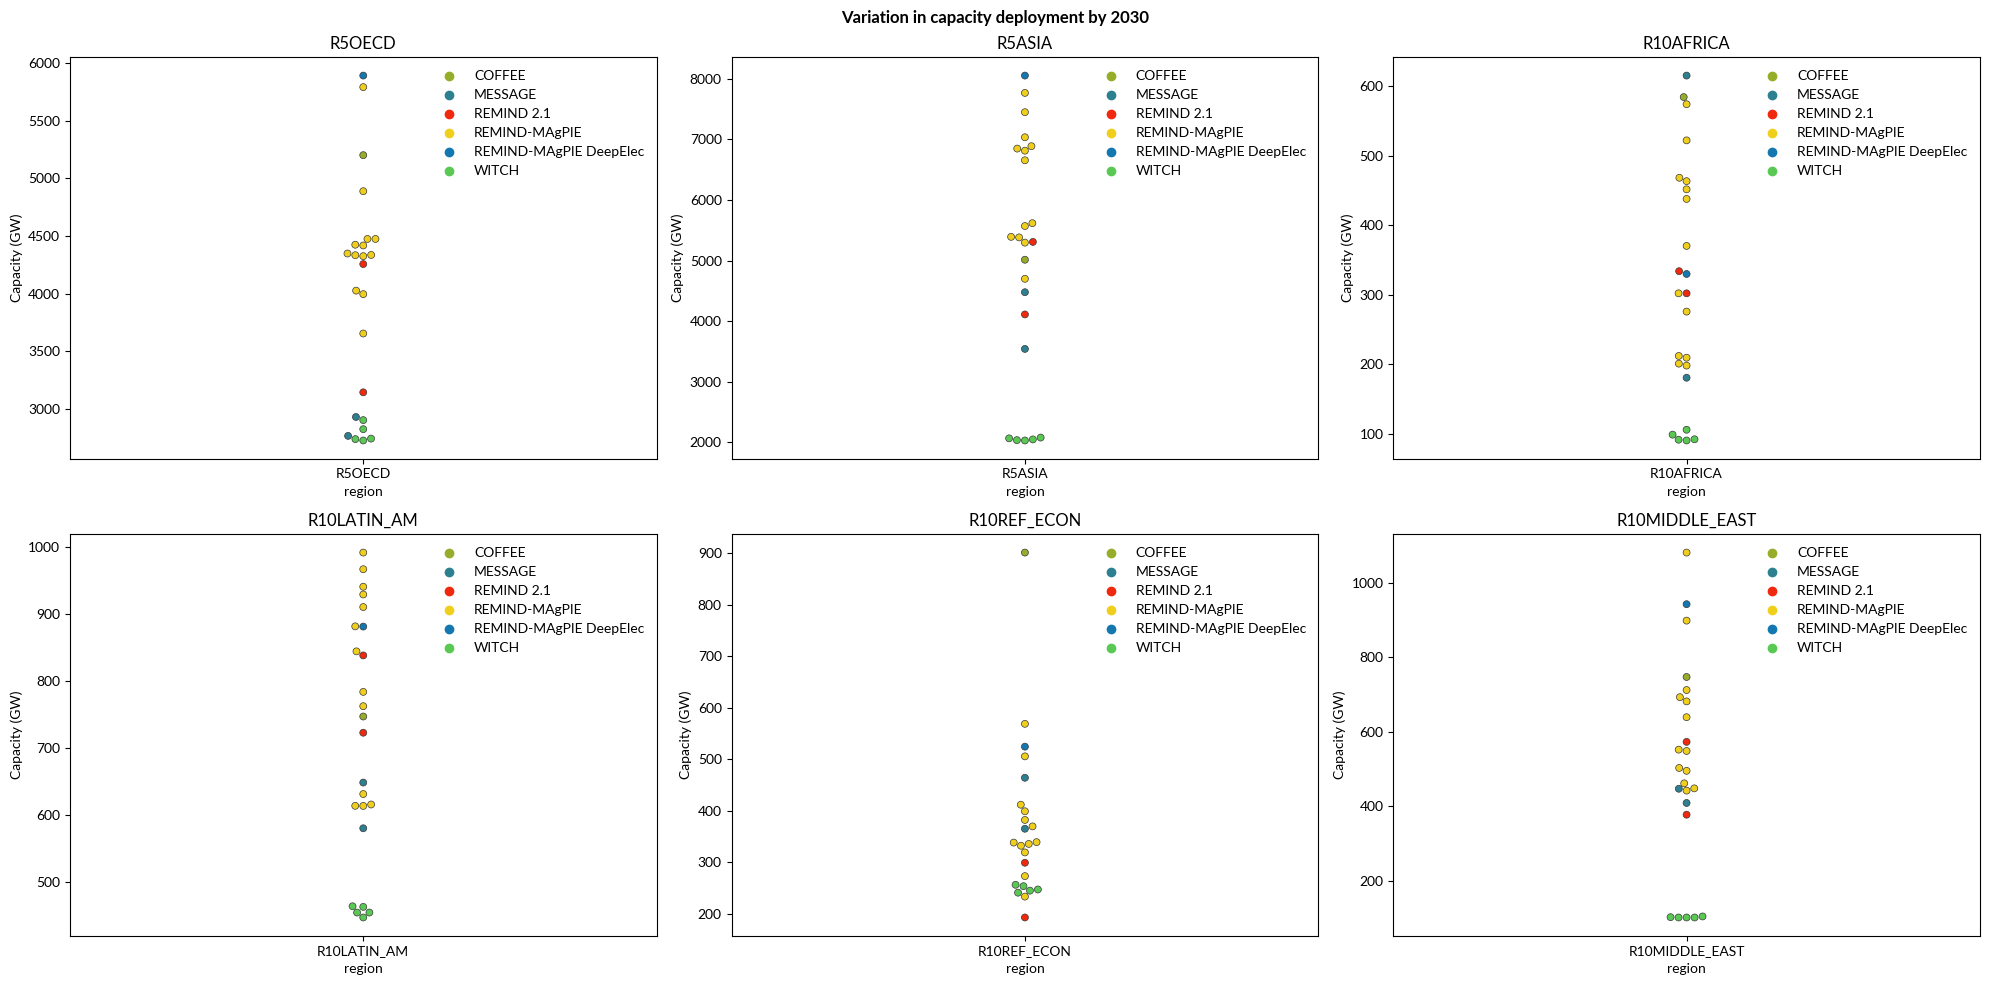

In [38]:
f, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))

for count, ax in enumerate(axes.ravel()):
    plt.sca(ax)
    sns.swarmplot(
            x='region',
            y='value',
            hue='model',
            data=plot_data.loc[plot_data.region == regions[count]],
            linewidth=0.5,
            ax=plt.gca()
    )
    ax.set_title(regions[count])
    ax.set_ylabel('Capacity (GW)')
    ax.legend(edgecolor='w',framealpha=0)

f.suptitle('Variation in capacity deployment by 2030',
           fontweight='bold')

plt.tight_layout()

In [39]:
cap_benchmarks = ar6_data.filter(pathway=filter_set_final,
                     variable=[cap('Renewables*'),cap('WnS')],
                     region=regions[:-1],
                     year=2030).timeseries().groupby(['region','variable']).median().unstack('variable')

cap_benchmarks.columns = cap_benchmarks.columns.droplevel(None)
cap_benchmarks.loc['World'] = cap_benchmarks.sum()

cap_benchmarks = pd.concat([
    cap_benchmarks,
    cap_benchmarks['Capacity|Electricity|Renewables']/cap_hist.loc[ismatch(region=regions,variable=['**Electricity|Renewables'])].groupby('region').sum()[2022],
    cap_benchmarks['Capacity|Electricity|WnS']/cap_hist.loc[ismatch(region=regions,variable=['**Electricity|WnS'])].groupby('region').sum()[2022],
    ((cap_benchmarks['Capacity|Electricity|Renewables']/cap_hist.loc[ismatch(region=regions,variable=['**Electricity|Renewables'])].groupby('region').sum()[2022])**(1/8.0)-1)*100,
    ((cap_benchmarks['Capacity|Electricity|WnS']/cap_hist.loc[ismatch(region=regions,variable=['**Electricity|WnS'])].groupby('region').sum()[2022])**(1/8.0)-1)*100
            # variable='Increase in Renewables capacity relative to 2022'
],axis=1)

cap_benchmarks.columns = ['Capacity|Electricity|Renewables',
                          'Capacity|Electricity|WnS',
                          'Renewable capacity relative to 2022',
                          'WnS capacity relative to 2022',
                          'Renewable CAGR required',
                          'WnS CAGR required']



cap_benchmarks.to_csv('../outputs/data/capacity_benchmarks.csv')
cap_benchmarks[cap_benchmarks.columns[:]]

Capacity|Electricity|Renewables  Capacity|Electricity|WnS  \
region                                                                      
R10AFRICA                                301.95                    203.92   
R10LATIN_AM                              734.91                    406.13   
R10MIDDLE_EAST                           499.30                    465.87   
R10REF_ECON                              336.84                    230.29   
R5ASIA                                  5346.24                   4489.77   
R5OECD                                  4291.53                   3608.24   
World                                  11510.77                   9404.21   

                Renewable capacity relative to 2022  \
region                                                
R10AFRICA                                      6.59   
R10LATIN_AM                                    2.33   
R10MIDDLE_EAST                                11.76   
R10REF_ECON                                    3.58   
R5ASIA                                         3.56   
R5OECD                                         3.10   
World                                          3.40   

                WnS capacity relative to 2022  Renewable CAGR required  \
region                                                                   
R10AFRICA                               15.28                    26.58   
R10LATIN_AM                              4.56                    11.14   
R10MIDDLE_EAST                          21.79                    36.08   
R10REF_ECON                             13.28                    17.27   
R5ASIA                                   4.78                    17.21   
R5OECD                                   4.10                    15.21   
World                                    4.80                    16.55   

                WnS CAGR required  
region                             
R10AFRICA                   40.62  
R10LATIN_AM                 20.89  
R10MIDDLE_EAST              46.99  
R10REF_ECON                 38.17  
R5ASIA                      21.59  
R5OECD                      19.30  
World                       21.65

We plot a smooth trajectory to reaching these 2030 values with a constant annual growth rate

In [40]:
cap_benchmarks_2035 = ar6_data.filter(pathway=filter_set_final,
                     variable=[cap('Renewables*')],
                     region=regions[:-1],
                     year=2035).timeseries().groupby(['region','variable']).median().unstack('variable')

cap_benchmarks_2035.columns = cap_benchmarks_2035.columns.droplevel(None)
cap_benchmarks_2035.loc['World'] = cap_benchmarks_2035.sum()

cap_benchmarks_2035 = pd.concat([
    cap_benchmarks_2035,cap_benchmarks_2035['Capacity|Electricity|Renewables']
    -cap_hist.loc[ismatch(region=regions,variable=['**Electricity|Renewables'])].groupby('region').sum()[2022],
    cap_benchmarks_2035['Capacity|Electricity|Renewables']
    /cap_hist.loc[ismatch(region=regions,variable=['**Electricity|Renewables'])].groupby('region').sum()[2022],
],axis=1)

cap_benchmarks_2035.columns = ['Capacity|Electricity|Renewables',
                               'Capacity additions needed',
                               'Renewable capacity relative to 2022']

cap_benchmarks_2035


Capacity|Electricity|Renewables  Capacity additions needed  \
region                                                                       
R10AFRICA                                596.68                     550.88   
R10LATIN_AM                             1032.95                     717.14   
R10MIDDLE_EAST                          1015.78                     973.32   
R10REF_ECON                              605.77                     511.61   
R5ASIA                                  8196.97                    6696.24   
R5OECD                                  6022.35                    4639.86   
World                                  17470.50                   14089.05   

                Renewable capacity relative to 2022  
region                                               
R10AFRICA                                     13.03  
R10LATIN_AM                                    3.27  
R10MIDDLE_EAST                                23.92  
R10REF_ECON                                    6.43  
R5ASIA                                         5.46  
R5OECD                                         4.36  
World                                          5.17

In [41]:
17.5/3.4

5.147058823529412

In [42]:
cap_benchmarks[cap('Renewables')] - cap_hist.loc[isin(
    region=regions,
    variable=cap('Renewables')),
    2022]

region          variable                         unit
R5OECD          Capacity|Electricity|Renewables  GW      2909.05
R5ASIA          Capacity|Electricity|Renewables  GW      3845.52
R10AFRICA       Capacity|Electricity|Renewables  GW       256.14
R10LATIN_AM     Capacity|Electricity|Renewables  GW       419.10
R10REF_ECON     Capacity|Electricity|Renewables  GW       242.67
R10MIDDLE_EAST  Capacity|Electricity|Renewables  GW       456.84
World           Capacity|Electricity|Renewables  GW      8129.31
dtype: float64

In [43]:
gr_1o5 = (
    (cap_benchmarks_range.loc[isin(scenario=[0.5,0.75,0.95]),cap('Renewables')]/
     cap_hist.loc[ismatch(region=regions,variable=['**Electricity|Renewables'])].groupby('region').sum()[2023])
    **(1/7.0)
)

rnw_cap_1o5 = pd.concat([cap_hist.loc[ismatch(region=regions,variable='**Renewables'),2023]*
                         gr_1o5**n for n in range(0,8)],axis=1)

rnw_cap_1o5
rnw_cap_1o5 = assignlevel(rnw_cap_1o5,
            scenario=['central','high','very high']*len(regions)
           )

rnw_cap_1o5.columns = range(2023,2031)
rnw_cap_1o5 = rnw_cap_1o5.reorder_levels(['region','scenario','variable','unit'])

In [44]:
cap_hist.loc[isin(region=oecd_isos,
                 variable=cap('Renewables')),
2022].sum()

1382.488775

In [45]:
98/1480

0.06621621621621622

In [46]:
cap_hist.loc[isin(region=['COL','MEX','CHL','CRI','KOR'],
                 variable=cap('Renewables')),
2022].sum()

98.488709

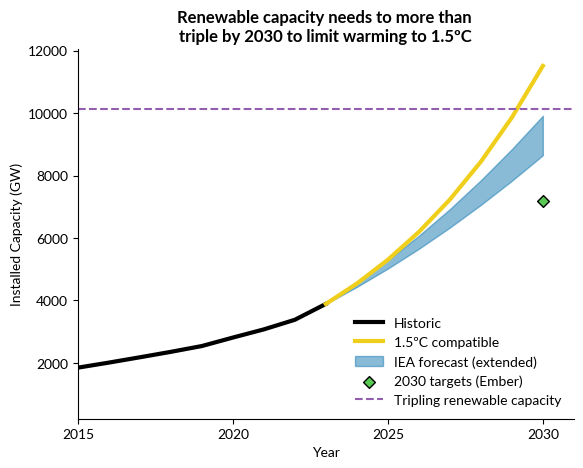

In [47]:
f, ax = plt.subplots()

cap_hist.loc[ismatch(region='World',variable='**Renewables')].T.plot(ax=ax,color='k',lw=3,label='Historic')
rnw_cap_1o5.loc[isin(region='World',scenario='central')].T.plot(ax=ax,color=ca_colors[3],lw=3)

#Take future capacity estimates from the IEA
ax.fill_between(
    range(2023,2031),
    cap_forecast.loc[isin(
        region='World',
        variable=cap('Renewables'),
        scenario='Main'),2023:].squeeze(),
    cap_forecast.loc[isin(
        region='World',
        variable=cap('Renewables'),
        scenario='Accelerated'),2023:].squeeze(),
    color=ca_colors[4],
    alpha=0.5
)


ax.scatter(2030,cap_targets_rescaled.loc[isin(region='World'),'res_capacity_target'],marker='D',color=ca_colors[5],edgecolors='k',linewidth=1)
ax.axhline(
    y=cap_hist.loc[ismatch(region='World',variable='**Renewables'),2022].squeeze()*3,
    color=ca_colors[7],
    ls='--')


ax.legend(['Historic','1.5ºC compatible','IEA forecast (extended)','2030 targets (Ember)','Tripling renewable capacity'],edgecolor='w')



ax.set_xlim([2015,2031])
ax.set_title('Renewable capacity needs to more than \ntriple by 2030 to limit warming to 1.5ºC',
            fontweight='bold')
ax.set_ylabel('Installed Capacity (GW)')
ax.set_xlabel('Year')
ax.set_xticks([2015,2020,2025,2030])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
                              
plt.savefig('../outputs/figures/global_renewables_capacity.png',dpi=300,bbox_inches='tight')

In [48]:
f, axes = plt.subplots(nrows=2,ncols=3,figsize=(12,8),sharey=False)

axr = axes.ravel()
rest = ['rest_oecd','rest_asia','rest_africa','rest_latam','rest_eurasia','rest_mideast']

for count, ax in enumerate(axr):
    cap_hist.loc[ismatch(region=regions[count],variable='**Renewables')].T.plot(ax=ax,color='k',lw=3,label='Historic')
    rnw_cap_1o5.loc[isin(region=regions[count],scenario='central')].T.plot(ax=ax,color=ca_colors[3],lw=3)

    ax.fill_between(
    range(2023,2031),
    cap_forecast.loc[isin(
        region=regions[count],
        variable=cap('Renewables'),
        scenario='Main'),2023:].squeeze(),
    cap_forecast.loc[isin(
        region=regions[count],
        variable=cap('Renewables'),
        scenario='Accelerated'),2023:].squeeze(),
    color=ca_colors[4],
    alpha=0.5,
        label='IEA forecast'
    )
   
    
    ax.set_xlim([2015,2031])
    ax.set_title(region_names[count])
    ax.set_ylabel('Capacity (GW)')
    ax.set_xticks([2015,2020,2025,2030])

for ax in axr[:]:
    ax.legend().set_visible(False)

for ax, region in zip(axr[[0,1,3]],['R5OECD','R5ASIA','R10LATIN_AM']):

    ax.scatter(2030,
               cap_targets.loc[isin(region=region),'res_capacity_target'],
               # future_capacity(regions=rest[count],techs=['WnS','Renewables|Non-WnS'],yr1=2017,yr2=2022,start_year=2022).loc['medium'].sum()[2030],
               marker='D',color=ca_colors[5],edgecolors='k',linewidth=1)


        
axr[0].legend(['Historic','1.5ºC compatible','IEA forecasts (extended)',
               '2030 targets (Ember)',
              ],edgecolor='w')

f.suptitle('1.5ºC compatible renewable capacity: a regional breakdown',fontweight='bold',
          fontsize=14)
plt.tight_layout()

plt.savefig('../outputs/figures/regional_renewables_capacity.png',dpi=300,bbox_inches='tight')

In [49]:
# Calculate growth rates required for 1.5ºC compatibility
(
    cap_benchmarks.loc[isin(region=regions),cap('Renewables')]
    /cap_hist.loc[isin(region=regions,variable=cap('Renewables')),2022]
)**(1/8)

region          variable                         unit
R5OECD          Capacity|Electricity|Renewables  GW      1.15
R5ASIA          Capacity|Electricity|Renewables  GW      1.17
R10AFRICA       Capacity|Electricity|Renewables  GW      1.27
R10LATIN_AM     Capacity|Electricity|Renewables  GW      1.11
R10REF_ECON     Capacity|Electricity|Renewables  GW      1.17
R10MIDDLE_EAST  Capacity|Electricity|Renewables  GW      1.36
World           Capacity|Electricity|Renewables  GW      1.17
dtype: float64

In [50]:
rnw_cap_1o5[2030]/cap_hist.loc[isin(region=regions,variable=cap('Renewables')),2022]

region          variable                         unit  scenario 
R10AFRICA       Capacity|Electricity|Renewables  GW    central       6.59
                                                       high          9.92
                                                       very high    12.73
R10LATIN_AM     Capacity|Electricity|Renewables  GW    central       2.33
                                                       high          2.79
                                                       very high     3.05
R10MIDDLE_EAST  Capacity|Electricity|Renewables  GW    central      11.76
                                                       high         16.13
                                                       very high    22.05
R10REF_ECON     Capacity|Electricity|Renewables  GW    central       3.58
                                                       high          4.27
                                                       very high     5.97
R5ASIA          Capacity|Electricity|Renewables

In [51]:
growth_required = pd.concat([
    (cap_hist[2022]/cap_hist[2014]).loc[isin(region=regions,variable=cap('Renewables'))],
    rnw_cap_1o5.loc[isin(scenario='central'),2030].droplevel('scenario')/cap_hist.loc[isin(region=regions,variable=cap('Renewables')),2022]
    ], axis=1)

growth_required.droplevel('unit')
growth_required.columns = ['Last 8 years','Next 8 years']
growth_required

Last 8 years  \
region         variable                        unit                 
R5OECD         Capacity|Electricity|Renewables GW            1.70   
R5ASIA         Capacity|Electricity|Renewables GW            2.67   
R10AFRICA      Capacity|Electricity|Renewables GW            1.87   
R10LATIN_AM    Capacity|Electricity|Renewables GW            1.61   
R10REF_ECON    Capacity|Electricity|Renewables GW            1.24   
R10MIDDLE_EAST Capacity|Electricity|Renewables GW            1.80   
World          Capacity|Electricity|Renewables GW            2.00   

                                                     Next 8 years  
region         variable                        unit                
R5OECD         Capacity|Electricity|Renewables GW            3.10  
R5ASIA         Capacity|Electricity|Renewables GW            3.56  
R10AFRICA      Capacity|Electricity|Renewables GW            6.59  
R10LATIN_AM    Capacity|Electricity|Renewables GW            2.33  
R10REF_ECON    Capacity|Electricity|Renewables GW            3.58  
R10MIDDLE_EAST Capacity|Electricity|Renewables GW           11.76  
World          Capacity|Electricity|Renewables GW            3.40

#### Compare capacity additions over time

In [52]:
f, ax = plt.subplots()

ax.bar(
    x=range(2018,2024),
    height=cap_hist.loc[isin(variable=cap('Renewables'),region='World'),2018:].diff(axis=1).squeeze(),
    width=0.9,
    color=ca_colors[5],
    lw=0,
    
    edgecolor='k')

ax.bar(
    x=range(2023,2031),
    height=rnw_cap_1o5.loc[isin(region='World',scenario='central')].diff(axis=1).squeeze(),
    width=0.9,
    color=ca_colors[6],
    lw=0,
    edgecolor='k')

ax.set_ylabel('Annual renewable capacity additions (GW)')
ax.set_title('Renewable capacity additions need to \nreach over 1500 GW per year by 2030',
             fontweight='bold')
ax.set_xlabel('Year')
ax.axvline(x=2023.5, lw=1, color=ca_colors[4], ls='--')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('../outputs/figures/global_renewables_capacity_additions.png',dpi=300,bbox_inches='tight')

#### Calculate capacity gap
As seen in the above figures, there is a gap in total capacity achieved in 2030 under the trendline of the past 5y, compared to 1.5ºC requirements. We calculate how this capacity gap is distributed across the regions

In [53]:
cap_benchmarks['Capacity|Electricity|Renewables']

region
R10AFRICA           301.95
R10LATIN_AM         734.91
R10MIDDLE_EAST      499.30
R10REF_ECON         336.84
R5ASIA             5346.24
R5OECD             4291.53
World             11510.77
Name: Capacity|Electricity|Renewables, dtype: float64

In [54]:
capacity_gap = pd.concat([
    cap_benchmarks['Capacity|Electricity|Renewables'], 
    cap_forecast.loc[isin(region=regions[:],variable=cap('Renewables'),),2030].groupby(['region']).min(),
    cap_forecast.loc[isin(region=regions[:],variable=cap('Renewables'),),2030].groupby(['region']).max(),
    cap_benchmarks['Capacity|Electricity|Renewables'] - 
    cap_forecast.loc[isin(region=regions[:],variable=cap('Renewables'),),2030].groupby(['region']).max(),
    cap_benchmarks['Capacity|Electricity|Renewables'] - 
    cap_forecast.loc[isin(region=regions[:],variable=cap('Renewables'),),2030].groupby(['region']).min()
],axis=1
)

capacity_gap.columns = ['Renewable capacity needed by 2030',
                        'Renewable capacity under forecasted trends (min)',
                        'Renewable capacity under forecasted trends (max)',
                        'Capacity gap (min)',
                        'Capacity gap (max)']

capacity_gap

Renewable capacity needed by 2030  \
region                                              
R10AFRICA                                  301.95   
R10LATIN_AM                                734.91   
R10MIDDLE_EAST                             499.30   
R10REF_ECON                                336.84   
R5ASIA                                    5346.24   
R5OECD                                    4291.53   
World                                    11510.77   

                Renewable capacity under forecasted trends (min)  \
region                                                             
R10AFRICA                                                 141.39   
R10LATIN_AM                                               510.85   
R10MIDDLE_EAST                                            142.66   
R10REF_ECON                                               121.40   
R5ASIA                                                   4978.10   
R5OECD                                                   2879.18   
World                                                    8650.44   

                Renewable capacity under forecasted trends (max)  \
region                                                             
R10AFRICA                                                 176.09   
R10LATIN_AM                                               537.86   
R10MIDDLE_EAST                                            211.55   
R10REF_ECON                                               152.48   
R5ASIA                                                   5667.15   
R5OECD                                                   3284.77   
World                                                    9914.42   

                Capacity gap (min)  Capacity gap (max)  
region                                                  
R10AFRICA                   125.85              160.56  
R10LATIN_AM                 197.05              224.05  
R10MIDDLE_EAST              287.76              356.64  
R10REF_ECON                 184.36              215.43  
R5ASIA                     -320.91              368.14  
R5OECD                     1006.76             1412.36  
World                      1596.35             2860.33

In [55]:
capacity_gap/capacity_gap.loc['World']

Renewable capacity needed by 2030  \
region                                              
R10AFRICA                                    0.03   
R10LATIN_AM                                  0.06   
R10MIDDLE_EAST                               0.04   
R10REF_ECON                                  0.03   
R5ASIA                                       0.46   
R5OECD                                       0.37   
World                                        1.00   

                Renewable capacity under forecasted trends (min)  \
region                                                             
R10AFRICA                                                   0.02   
R10LATIN_AM                                                 0.06   
R10MIDDLE_EAST                                              0.02   
R10REF_ECON                                                 0.01   
R5ASIA                                                      0.58   
R5OECD                                                      0.33   
World                                                       1.00   

                Renewable capacity under forecasted trends (max)  \
region                                                             
R10AFRICA                                                   0.02   
R10LATIN_AM                                                 0.05   
R10MIDDLE_EAST                                              0.02   
R10REF_ECON                                                 0.02   
R5ASIA                                                      0.57   
R5OECD                                                      0.33   
World                                                       1.00   

                Capacity gap (min)  Capacity gap (max)  
region                                                  
R10AFRICA                     0.08                0.06  
R10LATIN_AM                   0.12                0.08  
R10MIDDLE_EAST                0.18                0.12  
R10REF_ECON                   0.12                0.08  
R5ASIA                       -0.20                0.13  
R5OECD                        0.63                0.49  
World                         1.00                1.00

### Wind and Solar
Repeating the analysis but for wind and solar separately

In [56]:
gr_wns_1o5 = (
    (cap_benchmarks['Capacity|Electricity|WnS']/
     cap_hist.loc[ismatch(region=regions,variable=['**Electricity|WnS'])].groupby('region').sum()[2023])
    **(1/7.0)
)


wns_cap_1o5 = pd.concat([cap_hist.loc[ismatch(region=regions,variable='**|WnS'),2023]*
                         gr_wns_1o5**n for n in range(0,8)],axis=1)
wns_cap_1o5.columns = range(2023,2031)
wns_cap_1o5

2023     2024     2025  \
region         variable                 unit                              
R5OECD         Capacity|Electricity|WnS GW    1011.19  1212.71  1454.38   
R5ASIA         Capacity|Electricity|WnS GW    1249.18  1499.67  1800.39   
R10AFRICA      Capacity|Electricity|WnS GW      17.86    25.29    35.82   
R10LATIN_AM    Capacity|Electricity|WnS GW     113.86   136.54   163.74   
R10REF_ECON    Capacity|Electricity|WnS GW      19.37    27.59    39.29   
R10MIDDLE_EAST Capacity|Electricity|WnS GW      28.14    42.02    62.74   
World          Capacity|Electricity|WnS GW    2443.01  2961.78  3590.72   

                                                 2026     2027     2028  \
region         variable                 unit                              
R5OECD         Capacity|Electricity|WnS GW    1744.22  2091.83  2508.70   
R5ASIA         Capacity|Electricity|WnS GW    2161.42  2594.84  3115.17   
R10AFRICA      Capacity|Electricity|WnS GW      50.72    71.82   101.69   
R10LATIN_AM    Capacity|Electricity|WnS GW     196.36   235.48   282.40   
R10REF_ECON    Capacity|Electricity|WnS GW      55.96    79.70   113.52   
R10MIDDLE_EAST Capacity|Electricity|WnS GW      93.69   139.91   208.92   
World          Capacity|Electricity|WnS GW    4353.21  5277.62  6398.32   

                                                 2029     2030  
region         variable                 unit                    
R5OECD         Capacity|Electricity|WnS GW    3008.65  3608.24  
R5ASIA         Capacity|Electricity|WnS GW    3739.84  4489.77  
R10AFRICA      Capacity|Electricity|WnS GW     144.00   203.92  
R10LATIN_AM    Capacity|Electricity|WnS GW     338.66   406.13  
R10REF_ECON    Capacity|Electricity|WnS GW     161.69   230.29  
R10MIDDLE_EAST Capacity|Electricity|WnS GW     311.98   465.87  
World          Capacity|Electricity|WnS GW    7757.01  9404.21

In [57]:
f, axes = plt.subplots(nrows=2,ncols=3,figsize=(12,8),sharey=False)

axr = axes.ravel()
rest = ['rest_oecd','rest_asia','rest_africa','rest_latam','rest_eurasia','rest_mideast']

for count, ax in enumerate(axr):
    cap_hist.loc[ismatch(region=regions[count],variable=cap('WnS'))].T.plot(ax=ax,color='k',lw=3,label='Historic')
    wns_cap_1o5.loc[isin(region=regions[count])].T.plot(ax=ax,color=ca_colors[3],lw=3)

    ax.fill_between(
    range(2023,2031),
    cap_forecast.loc[isin(
        region=regions[count],
        variable=cap('WnS'),
        scenario='Main'),2023:].squeeze(),
    cap_forecast.loc[isin(
        region=regions[count],
        variable=cap('WnS'),
        scenario='Accelerated'),2023:].squeeze(),
    color=ca_colors[4],
    alpha=0.5,
        label='IEA forecast'
    )
   
    
    ax.set_xlim([2015,2031])
    ax.set_title(region_names[count])
    ax.set_ylabel('Capacity (GW)')
    ax.set_xticks([2015,2020,2025,2030])

for ax in axr[:]:
    ax.legend().set_visible(False)

for ax, region in zip(axr[[0,1,3]],['R5OECD','R5ASIA','R10LATIN_AM']):

    ax.scatter(2030,
               cap_targets.loc[isin(region=region),'wns_capacity_target'],
               # future_capacity(regions=rest[count],techs=['WnS','Renewables|Non-WnS'],yr1=2017,yr2=2022,start_year=2022).loc['medium'].sum()[2030],
               marker='D',color=ca_colors[5],edgecolors='k',linewidth=1)


        
axr[0].legend(['Historic','1.5ºC compatible','IEA forecasts',
               '2030 targets',
              ],edgecolor='w')

f.suptitle('1.5ºC compatible wind and solar capacity: a regional breakdown',fontweight='bold',
          fontsize=14)
plt.tight_layout()

plt.savefig('../outputs/figures/regional_wns_capacity.png',dpi=300,bbox_inches='tight')

### Regional deep dives
We then look at how the renewable capacity required in any given region could be achieved based on the historical growth rates of different countries. This can help identify which countries are 'laggards' or 'leaders'. This currently uses the `future_capacity_simple` function. 

In [58]:
def future_capacity(region,tech,growth_region,start_year=2023):
    future_df = (
        cap_forecast.loc[:,start_year:].divide(cap_forecast[start_year],axis=0)
        .loc[isin(region=growth_region,variable=tech)]
        *cap_hist.loc[isin(region=region,variable=tech),start_year].squeeze()
    )

    future_df = assignlevel(
        future_df,
        region=region)

    return future_df
        

#### Asia

In [59]:
import flagpy as fp
import matplotlib.patches as mpatches

In [60]:
def plot_flag(country):
    flag = fp.get_flag_img(country)
    extent = (-0.15,0.15,-0.1,+0.1)
    f, ax = plt.subplots(figsize=(1,2))
    #Add flag to axis
    ax.imshow(flag,extent=extent)
    # Create a border
    border = mpatches.Rectangle((-0.15,-0.1), 0.3, 0.2, linewidth=1, edgecolor='k', facecolor='none')
    ax.add_patch(border)

    #Get ride of axes
    ax.set_xlim([-0.2,0.2])
    ax.set_ylim([-0.15,0.15])
    ax.axis('off')
    plt.tight_layout()


In [61]:
plot_flag('China')

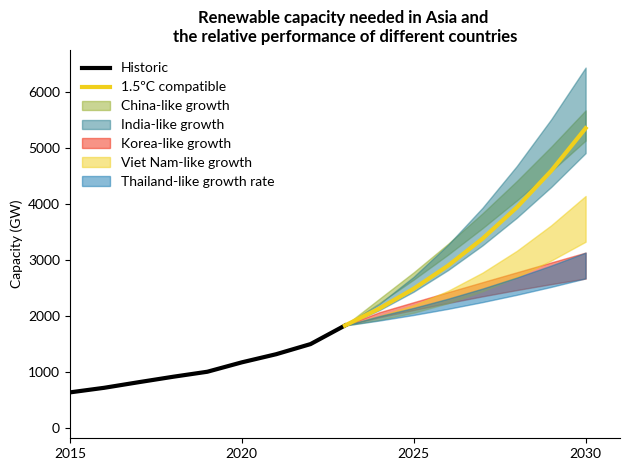

In [62]:
f, ax = plt.subplots()
plot_region = 'R5ASIA'

cap_hist.loc[ismatch(region=plot_region,variable='**Renewables')].T.plot(ax=ax,color='k',lw=3,label='Historic')
rnw_cap_1o5.loc[isin(region=plot_region,scenario='central')].T.plot(ax=ax,color=ca_colors[3],lw=3)


growth_regions = ['CHN','IND','KOR','VNM','THA',]

for region, color in zip(growth_regions,list(range(len(growth_regions)))):
    ax.fill_between(
        range(2023,2031),
        future_capacity('R5ASIA',cap('Renewables'),region).min(),
        future_capacity('R5ASIA',cap('Renewables'),region).max(),
        color=ca_colors[color],
        alpha=0.5,
        label=region
        )

# cap_plot = pd.concat([
#     cap_hist,
#     assignlevel(
#         cap_hist.loc['R5ASIA']-cap_hist.loc['CHN']-cap_hist.loc['IND'],
#         region='R5ASIA_noCHN_noIND').reorder_levels([2,0,1])
# ])

# cap_plot.loc[isin(
#     region=['CHN','IND','R5ASIA_noCHN_noIND'],
#     variable=cap('Renewables')),2015:].T.plot.area(
#     linewidth=0,
#     ax=plt.gca(),
#     color=[ca_colors[n] for n in [0,1,7]])

ax.legend(['Historic','1.5ºC compatible',
           'China-like growth','India-like growth',
           'Korea-like growth','Viet Nam-like growth',
           'Thailand-like growth rate'],
          edgecolor='w',loc='upper left')

ax.set_xlim([2015,2031])
ax.set_ylabel('Capacity (GW)')
ax.set_xticks([2015,2020,2025,2030])

ax.set_title('Renewable capacity needed in Asia and \nthe relative performance of different countries',fontweight='bold')
plt.tight_layout()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False) 

plt.savefig('../outputs/figures/rnw_cap_asia.png',dpi=300,bbox_inches='tight')

#### OECD

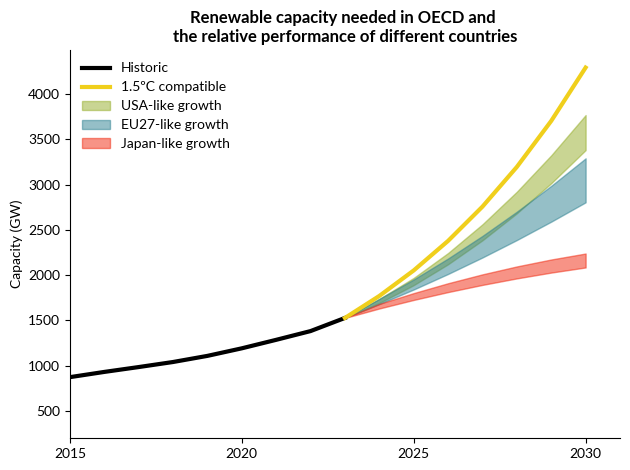

In [63]:
f, ax = plt.subplots()
plot_region = 'R5OECD'

cap_hist.loc[ismatch(region=plot_region,variable='**Renewables')].T.plot(ax=ax,color='k',lw=3,label='Historic')
rnw_cap_1o5.loc[isin(region=plot_region,scenario='central')].T.plot(ax=ax,color=ca_colors[3],lw=3)


growth_regions = ['USA','EU27','JPN']

for region, color in zip(growth_regions,list(range(len(growth_regions)))):
    ax.fill_between(
        range(2023,2031),
        future_capacity('R5OECD',cap('Renewables'),region).max(),
        future_capacity('R5OECD',cap('Renewables'),region).min(),
        color=ca_colors[color],
        alpha=0.5,
        label=region
        )

ax.legend(['Historic','1.5ºC compatible',
           'USA-like growth','EU27-like growth',
           'Japan-like growth','Korea-like growth'],
          edgecolor='w',loc='upper left')

# cap_plot = pd.concat([
#     cap_hist,
#     assignlevel(
#         cap_hist.loc['R5OECD']-cap_hist.loc['USA']-cap_hist.loc['EU27']-cap_hist.loc['JPN'],
#         region='R5OECD_noUSA_noEU_noJPN').reorder_levels([2,0,1])
# ])

# (cap_plot.loc[isin(variable=cap('Renewables')),2015:]
# .loc[['USA','EU27','JPN','R5OECD_noUSA_noEU_noJPN']]).T.plot.area(
#     linewidth=0,
#     ax=plt.gca(),
#     color=[ca_colors[n] for n in [0,1,2,7]],
#     alpha=0.7,
#     legend=False)


ax.set_xlim([2015,2031])
ax.set_ylabel('Capacity (GW)')
ax.set_xticks([2015,2020,2025,2030])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Renewable capacity needed in OECD and \nthe relative performance of different countries',fontweight='bold')
plt.tight_layout()

plt.savefig('../outputs/figures/rnw_cap_oecd.png',dpi=300,bbox_inches='tight')

#### Latin America

In [64]:
f, ax = plt.subplots()
plot_region = 'R10LATIN_AM'

cap_hist.loc[ismatch(region=plot_region,variable='**Renewables')].T.plot(ax=ax,color='k',lw=3,label='Historic')
rnw_cap_1o5.loc[isin(region=plot_region,scenario='central')].T.plot(ax=ax,color=ca_colors[3],lw=3)


growth_regions = ['BRA','CHL','ARG','MEX']

for region, color in zip(growth_regions,list(range(len(growth_regions)))):
    ax.fill_between(
        range(2023,2031),
        future_capacity('R10LATIN_AM',cap('Renewables'),region).max(),
        future_capacity('R10LATIN_AM',cap('Renewables'),region).min(),
        color=ca_colors[color],
        alpha=0.5,
        label=region
        )

ax.legend(['Historic','1.5ºC compatible',
           'Brazil-like growth','Chile-like growth',
           'Argentina-like growth','Mexico-like growth'],
          edgecolor='w',loc='upper left')
ax.set_xlim([2015,2031])
ax.set_ylabel('Capacity (GW)')
ax.set_xticks([2015,2020,2025,2030])

ax.set_title('Renewable capacity needed in Latin America and \nthe relative performance of different countries',fontweight='bold')
plt.tight_layout()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('../outputs/figures/rnw_cap_latam.png',dpi=300,bbox_inches='tight')

#### Middle East

In [65]:
f, ax = plt.subplots()
plot_region = 'R10MIDDLE_EAST'

cap_hist.loc[ismatch(region=plot_region,variable='**Renewables')].T.plot(ax=ax,color='k',lw=3,label='Historic')
rnw_cap_1o5.loc[isin(region=plot_region,scenario='central')].T.plot(ax=ax,color=ca_colors[3],lw=3)


growth_regions = ['ARE','ISR','MAR','SAU']

for region, color in zip(growth_regions,list(range(len(growth_regions)))):
    ax.fill_between(
        range(2023,2031),
        future_capacity(plot_region,cap('Renewables'),region).max(),
        future_capacity(plot_region,cap('Renewables'),region).min(),
        color=ca_colors[color],
        alpha=0.5,
        label=region
        )

ax.set_ylim([0,700])
ax.legend(['Historic','1.5ºC compatible',
           'UAE-like growth','Israel-like growth',
           'Morocco-like growth','Saudi-like growth'],
          edgecolor='w',loc='upper left')
ax.set_xlim([2015,2031])
ax.set_ylabel('Capacity (GW)')
ax.set_xticks([2015,2020,2025,2030])

ax.set_title('Renewable capacity needed in the MENA region and \nthe relative performance of different countries',fontweight='bold')
plt.tight_layout()

# plt.savefig('../outputs/figures/rnw_cap_oecd.png',dpi=300,bbox_inches='tight')

#### Africa

In [66]:
elec_mix_vars = [elec(tech) for tech in [None,'Coal','Gas','Hydro','Wind','Solar']]
cap_mix_vars = [cap(tech) for tech in ['Coal','Gas','Oil','Nuclear','WnS','Renewables']]

In the Sustainable Africa Scenario, in Sub-Saharan Africa:
- Total electricity demand grows from 450 TWh to 920 TWh over 2020–2030
- Coal generation falls from 200 TWh (almost all in ZAF) to 140 TWh
- Gas generation *rises* from ~50 TWh to ~100 TWh
- Wind ad Solar rise to 260 TWh from basically nothing
- Hydro rises from 120 TWh to 280TWh

How does the analysis here compare? 

In [67]:
africa_elec_mix = pd.concat(
    [   
        assignlevel(
            ar6_data.filter(
                pathway=pathways,
                region='R10AFRICA',
                variable=elec_mix_vars,
                year=range(2020,2051,5)).convert_unit(
                'EJ/yr','TWh / yr').timeseries().groupby('variable').median(),
            scenario=f'{filter_set_name}_median'
        )
        for pathways, filter_set_name in 
        zip([filter_set_24,filter_set_19,filter_set_32],
            ['regional_diff (24)','demand_filter (19)','no_regional_diff (32)'])
    ])
            

In [68]:
africa_elec_mix.sort_index(level='variable')

2020  \
variable                           scenario                               
Secondary Energy|Electricity       demand_filter (19)_median     552.03   
                                   no_regional_diff (32)_median  554.81   
                                   regional_diff (24)_median     554.60   
Secondary Energy|Electricity|Coal  demand_filter (19)_median     190.97   
                                   no_regional_diff (32)_median  216.06   
                                   regional_diff (24)_median     210.81   
Secondary Energy|Electricity|Gas   demand_filter (19)_median     121.64   
                                   no_regional_diff (32)_median  121.31   
                                   regional_diff (24)_median     121.64   
Secondary Energy|Electricity|Hydro demand_filter (19)_median     122.66   
                                   no_regional_diff (32)_median  122.66   
                                   regional_diff (24)_median     122.66   
Secondary Energy|Electricity|Solar demand_filter (19)_median      16.61   
                                   no_regional_diff (32)_median    8.97   
                                   regional_diff (24)_median      13.26   
Secondary Energy|Electricity|Wind  demand_filter (19)_median      18.00   
                                   no_regional_diff (32)_median   10.22   
                                   regional_diff (24)_median      17.24   

                                                                   2025  \
variable                           scenario                               
Secondary Energy|Electricity       demand_filter (19)_median     796.97   
                                   no_regional_diff (32)_median  603.77   
                                   regional_diff (24)_median     775.28   
Secondary Energy|Electricity|Coal  demand_filter (19)_median      99.47   
                                   no_regional_diff (32)_median   90.36   
                                   regional_diff (24)_median     118.64   
Secondary Energy|Electricity|Gas   demand_filter (19)_median     157.78   
                                   no_regional_diff (32)_median  120.34   
                                   regional_diff (24)_median     120.86   
Secondary Energy|Electricity|Hydro demand_filter (19)_median        NaN   
                                   no_regional_diff (32)_median     NaN   
                                   regional_diff (24)_median        NaN   
Secondary Energy|Electricity|Solar demand_filter (19)_median      93.07   
                                   no_regional_diff (32)_median   77.86   
                                   regional_diff (24)_median      75.25   
Secondary Energy|Electricity|Wind  demand_filter (19)_median      74.96   
                                   no_regional_diff (32)_median   44.70   
                                   regional_diff (24)_median      66.08   

                                                                    2030  \
variable                           scenario                                
Secondary Energy|Electricity       demand_filter (19)_median     1300.56   
                                   no_regional_diff (32)_median   908.88   
                                   regional_diff (24)_median     1207.07   
Secondary Energy|Electricity|Coal  demand_filter (19)_median       13.67   
                                   no_regional_diff (32)_median    13.67   
                                   regional_diff (24)_median       28.86   
Secondary Energy|Electricity|Gas   demand_filter (19)_median      106.97   
                                   no_regional_diff (32)_median   101.90   
                                   regional_diff (24)_median      113.39   
Secondary Energy|Electricity|Hydro demand_filter (19)_median      314.09   
                                   no_regional_diff (32)_median   314.09   
                                   regional_diff (24)_median      314.09   
S

From this, we see that only the set of 24/19 pathways provides enough electricity to meet universal energy access by 2030. (This is particularly true given that the IAMs start from a higher level of electricity generation than in historical data, and so need to provide less electricity to reach 920 TWh). This therefore suggests it would be good to use one of the 24 / 19 pathway sets.  

Both of these pathway sets see a faster reduction in coal generation (towards zero) and faster growth in wind and solar than in the SAS.  

For info - African electricity demand fell only 3% in COVID, so remained rather robust

In [69]:
africa_cap_mix = pd.concat(
    [   
        assignlevel(
            ar6_data.filter(
                pathway=pathways,
                region='R10AFRICA',
                variable=cap_mix_vars,
                year=range(2020,2051,5))
            .timeseries().groupby('variable').median(),
            scenario=f'{filter_set_name}_median'
        )
        for pathways, filter_set_name in 
        zip([filter_set_24,filter_set_19,filter_set_32],
            ['regional_diff (24)','demand_filter (19)','no_regional_diff (32)'])
    ])
            

In [70]:
ar6_data.filter(
    region='R10AFRICA',
    variable=elec(),
    pathway=filter_set_24,
    year=2030)._data.sort_values()

model                  scenario                             region     variable                      unit   year
WITCH 5.0              EN_NPi2020_500                       R10AFRICA  Secondary Energy|Electricity  EJ/yr  2030    2.04
                       EN_NPi2020_450                       R10AFRICA  Secondary Energy|Electricity  EJ/yr  2030    2.08
                       EN_NPi2020_400f                      R10AFRICA  Secondary Energy|Electricity  EJ/yr  2030    2.18
                       EN_NPi2020_450f                      R10AFRICA  Secondary Energy|Electricity  EJ/yr  2030    2.21
                       EN_NPi2020_500f                      R10AFRICA  Secondary Energy|Electricity  EJ/yr  2030    2.25
MESSAGEix-GLOBIOM_1.1  NGFS2_Net-Zero 2050                  R10AFRICA  Secondary Energy|Electricity  EJ/yr  2030    2.63
REMIND-MAgPIE 2.1-4.2  NGFS2_Net-Zero 2050 - IPD-95th       R10AFRICA  Secondary Energy|Electricity  EJ/yr  2030    2.67
                       NGFS2_Net-Zero 20

In [71]:
africa_cap_mix.sort_index(level='variable')

2020    2025  \
variable                        scenario                                      
Capacity|Electricity|Coal       demand_filter (19)_median     36.33   19.54   
                                no_regional_diff (32)_median  39.66   18.51   
                                regional_diff (24)_median     38.11   23.77   
Capacity|Electricity|Gas        demand_filter (19)_median     30.23   44.94   
                                no_regional_diff (32)_median  24.05   29.24   
                                regional_diff (24)_median     30.15   27.08   
Capacity|Electricity|Nuclear    demand_filter (19)_median      1.56    1.29   
                                no_regional_diff (32)_median   1.56    1.30   
                                regional_diff (24)_median      1.56    1.29   
Capacity|Electricity|Oil        demand_filter (19)_median      3.00    1.87   
                                no_regional_diff (32)_median   2.96    1.85   
                                regional_diff (24)_median      3.00    1.87   
Capacity|Electricity|Renewables demand_filter (19)_median     50.81  134.76   
                                no_regional_diff (32)_median  44.14  116.59   
                                regional_diff (24)_median     48.53  116.42   
Capacity|Electricity|WnS        demand_filter (19)_median     15.17   73.15   
                                no_regional_diff (32)_median   8.03   53.18   
                                regional_diff (24)_median     13.83   62.37   

                                                                2030  \
variable                        scenario                               
Capacity|Electricity|Coal       demand_filter (19)_median       5.11   
                                no_regional_diff (32)_median    2.60   
                                regional_diff (24)_median      11.76   
Capacity|Electricity|Gas        demand_filter (19)_median      36.27   
                                no_regional_diff (32)_median   30.75   
                                regional_diff (24)_median      24.57   
Capacity|Electricity|Nuclear    demand_filter (19)_median       1.03   
                                no_regional_diff (32)_median    1.04   
                                regional_diff (24)_median       1.03   
Capacity|Electricity|Oil        demand_filter (19)_median       0.66   
                                no_regional_diff (32)_median    0.65   
                                regional_diff (24)_median       0.66   
Capacity|Electricity|Renewables demand_filter (19)_median     333.80   
                                no_regional_diff (32)_median  234.08   
                                regional_diff (24)_median     301.95   
Capacity|Electricity|WnS        demand_filter (19)_median     250.97   
                                no_regional_diff (32)_median  154.15   
                                regional_diff (24)_median     203.92   

                                                                  2035  \
variable                        scenario                                 
Capacity|Electricity|Coal       demand_filter (19)_median     5.29e-02   
                                no_regional_diff (32)_median  5.83e-02   
                                regional_diff (24)_median     5.64e-02   
Capacity|Electricity|Gas        demand_filter (19)_median     3.31e+01   
                                no_regional_diff (32)_median  3.39e+01   
                                regional_diff (24)_median     2.58e+01   
Capacity|Electricity|Nuclear    demand_filter (19)_median     8.28e-01   
                                no_regional_diff (32)_median  8.42e-01   
                                regional_diff (24)_median     8.32e-01   
Capacity|Electricity|Oil        demand_filter (19)_median     1.00e-03   
                                no_regional_diff (32)_median  2.82e-01   
                                regional_diff (24)_median     1.00e-03   
Capac

# Investment Requirements
We now move on to explore the investment requirements for this transition. The first question here is whether to take investment data directly from the IAMs or from our own bottom-up calculations

## Compare IAM cost data to bottom-up cost data from IRENA
The IAMs often report their own cost data - we compare this to a bottom-up cost estimation of data produced by Tina using IRENA data

In [72]:
def name_to_iso(name):
    if pycountry.countries.get(name=name) is None:
        return name
    else:
        return  pycountry.countries.get(name=name).alpha_3


In [73]:
bottom_up_costs = pd.read_excel('../data/processed/regional_wns_costs.xlsx',
                                sheet_name='medium',
                                index_col=[0,1,2,3])
bottom_up_costs['iso'] = projectlevel(bottom_up_costs,'region').index.map(lambda country:name_to_iso(country))
bottom_up_costs.set_index('iso',append=True,inplace=True)
bottom_up_costs.columns = bottom_up_costs.columns.astype(int)
# bottom_up_costs = bottom_up_costs.T.reindex(range(2022,2051)).interpolate().T

bottom_up_costs.head()

2020  \
technology region                               scenario unit       iso                                             
Solar|PV   China                                Medium   USD2022/kW CHN                                    721.00   
           India                                Medium   USD2022/kW IND                                    661.00   
           Rest of Asia (excl. China and India) Medium   USD2022/kW Rest of Asia (excl. China and India)   894.71   
           Australia                            Medium   USD2022/kW AUS                                   1176.00   
           UK                                   Medium   USD2022/kW UK                                     937.00   

                                                                                                             2021  \
technology region                               scenario unit       iso                                             
Solar|PV   China                                Medium   USD2022/kW CHN                                    672.00   
           India                                Medium   USD2022/kW IND                                    631.00   
           Rest of Asia (excl. China and India) Medium   USD2022/kW Rest of Asia (excl. China and India)   843.88   
           Australia                            Medium   USD2022/kW AUS                                   1095.00   
           UK                                   Medium   USD2022/kW UK                                     907.00   

                                                                                                           2022  \
technology region                               scenario unit       iso                                           
Solar|PV   China                                Medium   USD2022/kW CHN                                   715.0   
           India                                Medium   USD2022/kW IND                                   640.0   
           Rest of Asia (excl. China and India) Medium   USD2022/kW Rest of Asia (excl. China and India)  876.4   
           Australia                            Medium   USD2022/kW AUS                                   876.4   
           UK                                   Medium   USD2022/kW UK                                    910.0   

                                                                                                            2030  \
technology region                               scenario unit       iso                                            
Solar|PV   China                                Medium   USD2022/kW CHN                                   512.59   
           India                                Medium   USD2022/kW IND                                   446.04   
           Rest of Asia (excl. China and India) Medium   USD2022/kW Rest of Asia (excl. China and India)  665.97   
           Australia                            Medium   USD2022/kW AUS                                   665.97   
           UK                                   Medium   USD2022/kW UK                                    683.67   

                                                                                                            2040  \
technology region                               scenario unit       iso                                            
Solar|PV   China                                Medium   USD2022/kW CHN                                   388.67   
           India                                Medium   USD2022/kW IND                                   334.98   
           Rest of Asia (excl. China and India) Medium   USD2022/kW Rest of Asia (excl. China and India)  516.07   
           Australia                            Medium   USD2022/kW AUS                                   516.07   
           UK                                   Medium   USD2022/kW UK                                    530.42   

                                     

In [74]:
top_down_costs = (
    ar6_data.filter(
        variable=[cost('Solar*'),cost('Wind*')],
        region=regions,
        pathway=filter_set_final)
 .convert_unit('US$2010/kW','US$2022/kW',factor=1.41)
 .timeseries().groupby(['region','variable']).median()
)

top_down_costs.head()

2015     2020     2025  \
region      variable                                                            
R10AFRICA   Capital Cost|Electricity|Solar|CSP      7511.32  7749.14  6620.84   
            Capital Cost|Electricity|Solar|PV       2296.66  1726.07  1022.26   
            Capital Cost|Electricity|Wind|Offshore  5893.13  5383.38  4948.25   
            Capital Cost|Electricity|Wind|Onshore   2072.02  1853.02  1505.58   
R10LATIN_AM Capital Cost|Electricity|Solar|CSP      7737.91  8075.90  6865.19   

                                                       2030     2035     2040  \
region      variable                                                            
R10AFRICA   Capital Cost|Electricity|Solar|CSP      5770.57  5208.01  4744.80   
            Capital Cost|Electricity|Solar|PV        738.55   611.06   530.49   
            Capital Cost|Electricity|Wind|Offshore  4522.98  4164.40  3870.92   
            Capital Cost|Electricity|Wind|Onshore   1215.37   984.59   820.77   
R10LATIN_AM Capital Cost|Electricity|Solar|CSP      5946.86  5315.17  4811.00   

                                                       2045     2050     2055  \
region      variable                                                            
R10AFRICA   Capital Cost|Electricity|Solar|CSP      4256.49  3774.49  3578.79   
            Capital Cost|Electricity|Solar|PV        479.17   434.42   414.72   
            Capital Cost|Electricity|Wind|Offshore  3625.30  3447.12  3309.94   
            Capital Cost|Electricity|Wind|Onshore    780.96   780.96   780.96   
R10LATIN_AM Capital Cost|Electricity|Solar|CSP      4273.56  3747.22  3551.52   

                                                       2060     2070     2080  \
region      variable                                                            
R10AFRICA   Capital Cost|Electricity|Solar|CSP      3441.21  3378.16  3296.77   
            Capital Cost|Electricity|Solar|PV        392.74   376.79   351.93   
            Capital Cost|Electricity|Wind|Offshore  3197.38  3038.26  2929.87   
            Capital Cost|Electricity|Wind|Onshore    780.96   780.96   780.96   
R10LATIN_AM Capital Cost|Electricity|Solar|CSP      3416.51  3354.38  3272.99   

                                                       2090     2100  \
region      variable                                                   
R10AFRICA   Capital Cost|Electricity|Solar|CSP      3210.99  3105.30   
            Capital Cost|Electricity|Solar|PV        333.84   319.24   
            Capital Cost|Electricity|Wind|Offshore  2841.09  2761.05   
            Capital Cost|Electricity|Wind|Onshore    780.96   780.96   
R10LATIN_AM Capital Cost|Electricity|Solar|CSP      3187.22  3081.53   

                                                        2010     2005  \
region      variable                                                    
R10AFRICA   Capital Cost|Electricity|Solar|CSP       7523.65      NaN   
            Capital Cost|Electricity|Solar|PV        3436.02  6723.13   
            Capital Cost|Electricity|Wind|Offshore   6081.01      NaN   
            Capital Cost|Electricity|Wind|Onshore    2373.40      NaN   
R10LATIN_AM Capital Cost|Electricity|Solar|CSP      11787.85      NaN   

                                                       2065     2075     2085  \
region      variable                                                            
R10AFRICA   Capital Cost|Electricity|Solar|CSP      1952.39  1952.39  1952.39   
            Capital Cost|Electricity|Solar|PV        390.48   390.48   390.48   
            Capital Cost|Electricity|Wind|Offshore  3115.17  2982.23  2880.86   
            Capital Cost|Electricity|Wind|Onshore    780.96   780.96   780.96   
R10LATIN_AM Capital Cost|Electricity|Solar|CSP      1952.39  1952.39  1952.39   

                                                       2095  
region      variable                                         
R10AFRICA   Capital Cost|Electricity|Solar|CSP      1952.39  
            

In [75]:
f, axes = plt.subplots(nrows=2,ncols=3,figsize=(12,8),sharey=False)

axr = axes.ravel()

plot_regions = [
    ['EU27','United States'],
    ['China','India','Rest of Asia (excl. China and India)'],
    ['Africa','South Africa'],
    ['Central America and Caribbean','Brazil','Other South America'],
    ['Eurasia'],
    ['Egypt','Morocco','Saudi Arabia','UAE']
]

for count, ax in enumerate(axr):
    try:
        projectlevel(
            bottom_up_costs.loc[isin(region=plot_regions[count],technology='Solar|PV'),[2022,2030]],
            'region').T.plot(ax=ax)
    except:
        continue
#     
    projectlevel(
        top_down_costs.loc[isin(region=regions[count],variable=cost('Solar|PV')),
        [2020,2025,2030]],
        'region').T.plot(ax=ax,color=ca_colors[7])
        
    ax.set_xlim([2020,2031])
    ax.set_title(region_names[count])
    ax.set_ylabel('Capital Costs (\$$_{2022}$/kW)')

f.suptitle('Solar PV costs in the scenarios',fontweight='bold')
plt.tight_layout()


In [76]:
f, axes = plt.subplots(nrows=2,ncols=3,figsize=(12,8),sharey=False)

axr = axes.ravel()

for count, ax in enumerate(axr):
    try:
        projectlevel(
            bottom_up_costs.loc[isin(region=plot_regions[count],technology='Wind|Onshore'),[2022,2030]],
            'region').T.plot(ax=ax)
    except:
        continue
#     
    projectlevel(
        top_down_costs.loc[isin(region=regions[count],variable=cost('Wind|Onshore')),
        [2020,2025,2030]],
        'region').T.plot(ax=ax,color=ca_colors[7])
        
    ax.set_xlim([2020,2031])
    ax.set_title(region_names[count])
    ax.set_ylabel('Capital Costs (\$$_{2022}$/kW)')

f.suptitle('Wind|Onshore costs in the scenarios',fontweight='bold')
plt.tight_layout()


In [77]:
f, axes = plt.subplots(nrows=2,ncols=3,figsize=(12,8),sharey=False)

axr = axes.ravel()

for count, ax in enumerate(axr):
    try:
        projectlevel(
            bottom_up_costs.loc[isin(region=plot_regions[count],technology='Wind|Offshore'),[2022,2030]],
            'region').T.plot(ax=ax)
    except:
        continue
#     
    projectlevel(
        top_down_costs.loc[isin(region=regions[count],variable=cost('Wind|Offshore')),
        [2015,2020,2025,2030]],
        'region').T.plot(ax=ax,color=ca_colors[7])
        
    ax.set_xlim([2020,2031])
    ax.set_title(region_names[count])
    ax.set_ylabel('Capital Costs (\$$_{2022}$/kW)')

f.suptitle('Wind|Offshore costs in the scenarios',fontweight='bold')
plt.tight_layout()


We see that the cost data from the IAMs is often higher than the data from the bottom up method. This suggests that there could be merit in doing our own bottom-up calculations to estimate investment requirements

## Bottom-up investment calculations
We take cost data from IRENA here. To produce regional values, we weight the national values from IRENA by the share of capacity in 2022 covered by each country within the region. E.g. the regional value for Asia is a weighted average of China, India and Rest of Asia cost data, weighted by their capacity shares in 2022.

In [78]:
regional_costs = pd.read_excel('../data/processed/regional_wns_costs.xlsx',
                               sheet_name='regional_averages',
                              index_col=[0,1,2,3])

regional_costs

2020  \
region         scenario variable                               unit                  
R5ASIA         medium   Capital Cost|Electricity|Solar|PV      USD2022/kW   735.08   
                        Capital Cost|Electricity|Wind|Offshore USD2022/kW  2868.46   
                        Capital Cost|Electricity|Wind|Onshore  USD2022/kW  1389.41   
                        Capital Cost|Electricity|Wind          USD2022/kW  1503.61   
R5OECD         medium   Capital Cost|Electricity|Solar|PV      USD2022/kW  1212.97   
...                                                                            ...   
R10REF_ECON    low      Capital Cost|Electricity|Wind          USD2022/kW      NaN   
R10MIDDLE_EAST low      Capital Cost|Electricity|Solar|PV      USD2022/kW      NaN   
                        Capital Cost|Electricity|Wind|Onshore  USD2022/kW      NaN   
                        Capital Cost|Electricity|Wind|Offshore USD2022/kW      NaN   
                        Capital Cost|Electricity|Wind          USD2022/kW      NaN   

                                                                              2021  \
region         scenario variable                               unit                  
R5ASIA         medium   Capital Cost|Electricity|Solar|PV      USD2022/kW   688.16   
                        Capital Cost|Electricity|Wind|Offshore USD2022/kW  2513.74   
                        Capital Cost|Electricity|Wind|Onshore  USD2022/kW  1224.43   
                        Capital Cost|Electricity|Wind          USD2022/kW  1323.98   
R5OECD         medium   Capital Cost|Electricity|Solar|PV      USD2022/kW  1117.65   
...                                                                            ...   
R10REF_ECON    low      Capital Cost|Electricity|Wind          USD2022/kW      NaN   
R10MIDDLE_EAST low      Capital Cost|Electricity|Solar|PV      USD2022/kW      NaN   
                        Capital Cost|Electricity|Wind|Onshore  USD2022/kW      NaN   
                        Capital Cost|Electricity|Wind|Offshore USD2022/kW      NaN   
                        Capital Cost|Electricity|Wind          USD2022/kW      NaN   

                                                                              2022  \
region         scenario variable                               unit                  
R5ASIA         medium   Capital Cost|Electricity|Solar|PV      USD2022/kW   725.75   
                        Capital Cost|Electricity|Wind|Offshore USD2022/kW  2850.61   
                        Capital Cost|Electricity|Wind|Onshore  USD2022/kW  1121.15   
                        Capital Cost|Electricity|Wind          USD2022/kW  1254.69   
R5OECD         medium   Capital Cost|Electricity|Solar|PV      USD2022/kW  1097.98   
...                                                                            ...   
R10REF_ECON    low      Capital Cost|Electricity|Wind          USD2022/kW  1343.00   
R10MIDDLE_EAST low      Capital Cost|Electricity|Solar|PV      USD2022/kW   545.52   
                        Capital Cost|Electricity|Wind|Onshore  USD2022/kW  1529.42   
                        Capital Cost|Electricity|Wind|Offshore USD2022/kW  2197.38   
                        Capital Cost|Electricity|Wind          USD2022/kW  1529.42   

                                                                              2030  
region         scenario variable                               unit                 
R5ASIA         medium   Capital Cost|Electricity|Solar|PV      USD2022/kW   523.38  
                        Capital Cost|Electricity|Wind|Offshore USD2022/kW  2380.89  
                        Capital Cost|Electricity|Wind|Onshore  USD2022/kW  1068.89  
                        Capital Cost|Electricity|Wind          USD2022/kW  1170.20  
R5OECD         medium   Capital Cost|Electricity|Solar|PV      USD2022/kW   733.78  
...                                                                            ...  
R10REF_ECON    low      Capital Cost|Elec

There are two ways to calculate capacity additions -> directly from capacity additions data in the models, and inferring it from capacity data.  
- Not all models report capacity additions data –> this had to be inferred in the missing models based on capacity data
- Setting capacity additions to just be the annual difference in total capacity only calculates *net* capacity additions, not *gross* capacity additions (if there are some capacity retirements this would not be accounted for here).


We try both approaches here

### Approach 1: Capacity additions data

In [79]:
wns_cap_adds_1 = (ar6_data.filter(
    pathway=filter_set_final,
    region=regions,
    variable=[cap_add('Wind'),cap_add('Solar|PV')],
    year=[2020,2025,2030])
 .interpolate(time=range(2020,2031))
 .timeseries()
 .drop(2030,axis=1)
 .groupby(['region','variable']).median())


wns_investment_bottom_up_1 = ((
 wns_cap_adds_1
 *regional_costs.loc[isin(scenario='medium')]
 .rename(index=lambda x:x.replace('Capital Cost','Capacity Additions'))
 .T.reindex(range(2020,2030)).interpolate().T.
 fillna(method='bfill',axis=1)
 .droplevel('unit')
)
 .dropna().sum(axis=1)
 .unstack('variable')/1e3
)

wns_investment_bottom_up_1.columns = [inv('Solar|PV'),inv('Wind')]
print(
    f'Total investment needs over the 2020s of {wns_investment_bottom_up_1.sum().sum()} billion USD2022 \n for WnS deployment')

wns_investment_bottom_up_1.sum(axis=1)

Total investment needs over the 2020s of 7959.896479042844 billion USD2022 
 for WnS deployment


region          scenario
R10AFRICA       medium       201.28
R10LATIN_AM     medium       314.77
R10MIDDLE_EAST  medium       387.27
R10REF_ECON     medium       212.63
R5ASIA          medium      3384.72
R5OECD          medium      3459.22
dtype: float64

### Approach 2: Calculate capacity additions by applying pd.diff to the total capacity data

In [80]:
wns_cap_adds_2 = (ar6_data.filter(
    pathway=filter_set_final,
    region=regions,
    variable=[cap('Wind'),cap('Solar|PV')],
    year=[2020,2025,2030])
 .interpolate(time=range(2024,2031))
 .timeseries().groupby(['region','variable']).median()
 .diff(axis=1,periods=-1)*-1
)


wns_investment_bottom_up_2 = ((
 wns_cap_adds_2
 *regional_costs.loc[isin(scenario='medium')]
 .rename(index=lambda x:x.replace('Capital Cost','Capacity'))
 .T.reindex(range(2020,2031)).interpolate().T.
 fillna(method='bfill',axis=1)
 .droplevel('unit')
)
 .dropna(thresh=2).sum(axis=1)
 .unstack('variable')/1e3
)

wns_investment_bottom_up_2.columns = [inv('Solar|PV'),inv('Wind')]
print(
    f'Total investment needs over the 2020s of {wns_investment_bottom_up_2.sum().sum()} billion USD2022 \n for WnS deployment')

wns_investment_bottom_up_2.sum(axis=1)

Total investment needs over the 2020s of 7905.201916612094 billion USD2022 
 for WnS deployment


region          scenario
R10AFRICA       medium       201.91
R10LATIN_AM     medium       305.40
R10MIDDLE_EAST  medium       407.02
R10REF_ECON     medium       215.12
R5ASIA          medium      3385.24
R5OECD          medium      3390.52
dtype: float64

## Top-down investment calculations
Instead of doing a bottom-up estimate of the investment requirements, we can also take the top-down data from the IAMs.  
This allows us to look not only at wind and solar investment requirements, but also transmission/distribution requirements as well.
However, not all IAMs provide investment data -> this data is missing from the COFFEE scenario, from the REMIND 2.1 scenarios, and from the CEMICS, SusDev and DeepElec REMIND-MAgPIE pathways (only provided for the REMIND NGFS and REMIND ENGAGE scenarios). These values had to be calculated separately based on the relationship between investment, capacity and electricity generation in the scenarios which do report this data. For more details see `process_data.ipynb`

In [81]:
usd_2010_2022_deflator = 1.34 #Source: https://www.in2013dollars.com/us/inflation/2010?endYear=2022&amount=1

In [82]:
ar6_data.convert_unit('billion USD_2010/yr','billion USD_2022/yr',factor=usd_2010_2022_deflator,inplace=True)

In [83]:
inv_benchmarks_topdown = (ar6_data
 .filter(
     pathway=filter_set_24,
     variable=[inv(),inv('Renewables'),inv('WnS'),inv('Tr**Storage'),inv('Fossil'),inv('Nuclear')],
     region=regions[:-1],
     year=range(2020,2031))
 .interpolate(time=range(2020,2031))
 .timeseries().loc[:,2020:2029].sum(axis=1)
 .groupby(['region','variable']).median()).unstack('variable')

inv_benchmarks_topdown = inv_benchmarks_topdown[inv_benchmarks_topdown.columns[[0,3,5,4,2,1]]]

inv_benchmarks_topdown.loc[:,inv('Other')] = inv_benchmarks_topdown.loc[:,[inv('Fossil'),inv('Nuclear')]].sum(axis=1)
#Recalculate the total as the sum of renewables + grids + other (to ensure consistency within a region)
inv_benchmarks_topdown[inv()] = inv_benchmarks_topdown[[inv('Renewables'),inv('Transmission, Distribution and Storage'),inv('Other')]].sum(axis=1)
#Recalculate the global total as the sum of the regional totals
inv_benchmarks_topdown.loc['World'] = inv_benchmarks_topdown.sum()
inv_benchmarks_topdown

variable        Investment|Energy Supply|Electricity  \
region                                                 
R10AFRICA                                     942.21   
R10LATIN_AM                                  1609.06   
R10MIDDLE_EAST                               1407.88   
R10REF_ECON                                   922.36   
R5ASIA                                       9058.58   
R5OECD                                       7752.41   
World                                       21692.50   

variable        Investment|Energy Supply|Electricity|Renewables  \
region                                                            
R10AFRICA                                                491.27   
R10LATIN_AM                                              802.78   
R10MIDDLE_EAST                                           701.08   
R10REF_ECON                                              485.83   
R5ASIA                                                  5191.02   
R5OECD                                                  4018.43   
World                                                  11690.42   

variable        Investment|Energy Supply|Electricity|WnS  \
region                                                     
R10AFRICA                                         275.14   
R10LATIN_AM                                       486.03   
R10MIDDLE_EAST                                    666.54   
R10REF_ECON                                       315.00   
R5ASIA                                           4251.73   
R5OECD                                           3402.65   
World                                            9397.10   

variable        Investment|Energy Supply|Electricity|Transmission, Distribution and Storage  \
region                                                                                        
R10AFRICA                                                  420.95                             
R10LATIN_AM                                                786.11                             
R10MIDDLE_EAST                                             567.67                             
R10REF_ECON                                                326.47                             
R5ASIA                                                    2441.74                             
R5OECD                                                    3393.55                             
World                                                     7936.50                             

variable        Investment|Energy Supply|Electricity|Nuclear  \
region                                                         
R10AFRICA                                               0.18   
R10LATIN_AM                                             5.38   
R10MIDDLE_EAST                                         33.33   
R10REF_ECON                                            62.55   
R5ASIA                                                460.90   
R5OECD                                                161.00   
World                                                 723.33   

variable        Investment|Energy Supply|Electricity|Fossil  \
region                                                        
R10AFRICA                                             29.80   
R10LATIN_AM                                           14.78   
R10MIDDLE_EAST                                       105.81   
R10REF_ECON                                           47.51   
R5ASIA                                               964.91   
R5OECD                                               179.44   
World                                               1342.26   

variable        Investment|Energy Supply|Electricity|Other  
region                                                      
R10AFRICA                                            29.98  
R10LATIN_AM                                          20.16  
R10MIDDLE_EAST                                      139.14  
R10REF_ECON                                 

## Compare IAM data on grid investment to data from IRENA/IEA

In [84]:
iea_grid_inv_23 = 600*cap_benchmarks.loc['World',cap('Renewables')]/11000 
#USD2022 in grids + storage, average from 2023 to 2030, scaled to the level of renewable capacity observed in the IAMs

irena_grid_inv_23 = 605*(1.34/1.41)*cap_benchmarks.loc['World',cap('Renewables')]/11274 
#USD2022 in grids + storage, average from 2023 to 2030, scaled to the level of renewable capacity observed in the IAMs


mean_hist_inv = inv_hist.loc[isin(
    region='World',
    variable='Grids and Storage'),
    2020:2022].mean(axis=1).squeeze() #USD2022 in grids+storage, average from 2020 to 2022

iea_grid_inv_decade = iea_grid_inv_23*0.7+mean_hist_inv*0.3
irena_grid_inv_decade = irena_grid_inv_23*0.7+mean_hist_inv*0.3

print(iea_grid_inv_decade,irena_grid_inv_decade)

536.8060148253636 508.23162208241496


In [85]:
np.mean([iea_grid_inv_decade,irena_grid_inv_decade])*10

5225.1881845388925

In [86]:
grid_scaling_factor = (
    np.mean([iea_grid_inv_decade,irena_grid_inv_decade])*10 / 
    inv_benchmarks_topdown.loc['World',inv('Transmission, Distribution and Storage')]
)
grid_scaling_factor

0.6583747367269962

## Blend results
It seems that for renewables (where a bottom-up cost estimation is possible), it makes sense to use the bottom-up approach. It also seems (from both the IEA and IRENA, that the IAM's grid capacity investment requirements are ~50% too large)

We therefore produce a blended estimate of investments, where:
- Renewables + WnS estimates come directly from the bottom-up approach
- Grid investment numbers come from IRENA/IEA, but with the regional breakdown provided by the IAMs
- Other investment data is provided directly from the IAMs

In [87]:
(wns_investment_bottom_up_1.sum(axis=1)+wns_investment_bottom_up_2.sum(axis=1))/2

region          scenario
R10AFRICA       medium       201.60
R10LATIN_AM     medium       310.08
R10MIDDLE_EAST  medium       397.15
R10REF_ECON     medium       213.88
R5ASIA          medium      3384.98
R5OECD          medium      3424.87
dtype: float64

In [88]:
inv_benchmarks = inv_benchmarks_topdown.loc[regions[:-1]].copy()

# Delta inv is the reduction in investment needed in WnS / Renewables / Total due to the cheaper WnS costs estimates calculated from the bottom-up approach
delta_inv_rnw = (
    (wns_investment_bottom_up_1.sum(axis=1)+wns_investment_bottom_up_2.sum(axis=1))
    .droplevel('scenario')/2  #Take the mean of the two approaches for estimating WnS investments
    - inv_benchmarks[inv('WnS')])

for tech in ['Renewables','WnS']:
    inv_benchmarks[inv(tech)] = (inv_benchmarks[inv(tech)] + delta_inv_rnw)

# Rescale the grid estimate also
inv_benchmarks[inv('Transmission, Distribution and Storage')] = inv_benchmarks[inv('Transmission, Distribution and Storage')]*grid_scaling_factor


inv_benchmarks[inv()] = inv_benchmarks[[inv('Renewables'),inv('Transmission, Distribution and Storage'),inv('Other')]].sum(axis=1)
inv_benchmarks[inv('Renewables and Grids')] = inv_benchmarks[[inv('Renewables'),inv('Transmission, Distribution and Storage')]].sum(axis=1)
inv_benchmarks.loc['World'] = inv_benchmarks.sum()

inv_benchmarks.rename(index=lambda s:dict(zip(regions,region_names))[s],
                      inplace=True)

inv_benchmarks

variable                      Investment|Energy Supply|Electricity  \
region                                                               
OECD                                                       6615.31   
Asia                                                       7357.67   
Sub-Saharan Africa                                          724.86   
Latin America                                              1164.56   
Eurasia                                                     709.70   
Middle East and North Africa                                944.55   
World                                                     17516.65   

variable                      Investment|Energy Supply|Electricity|Renewables  \
region                                                                          
OECD                                                                  4040.65   
Asia                                                                  4324.27   
Sub-Saharan Africa                                                     417.73   
Latin America                                                          626.84   
Eurasia                                                                384.70   
Middle East and North Africa                                           431.68   
World                                                                10225.87   

variable                      Investment|Energy Supply|Electricity|WnS  \
region                                                                   
OECD                                                           3424.87   
Asia                                                           3384.98   
Sub-Saharan Africa                                              201.60   
Latin America                                                   310.08   
Eurasia                                                         213.88   
Middle East and North Africa                                    397.15   
World                                                          7932.55   

variable                      Investment|Energy Supply|Electricity|Transmission, Distribution and Storage  \
region                                                                                                      
OECD                                                                    2234.23                             
Asia                                                                    1607.58                             
Sub-Saharan Africa                                                       277.15                             
Latin America                                                            517.56                             
Eurasia                                                                  214.94                             
Middle East and North Africa                                             373.74                             
World                                                                   5225.19                             

variable                      Investment|Energy Supply|Electricity|Nuclear  \
region                                                                       
OECD                                                                161.00   
Asia                                                                460.90   
Sub-Saharan Africa                                                    0.18   
Latin America                                                         5.38   
Eurasia                                                              62.55   
Middle East and North Africa                                         33.33   
World                                                               723.33   

variable                      Investment|Energy Supply|Electricity|Fossil  \
region                                                                      
OECD                                                               179.44   
Asia                                                    

## Compare to current investment levels in the region and rescale
The 1.5ºC compatible scenarios provide investment data for 2020-2030 as a whole. We then subtract the investment already made from 2020-2023, which allows us to provide investment requirements from 2024 onwards.

In [89]:
def df_compare(hist_var,model_var):
    df_compare = pd.concat([
        projectlevel(
            inv_hist.loc[isin(
                region=inv_benchmarks.index,
                variable=hist_var),2020:].sum(axis=1),
            'region'),
        inv_benchmarks[model_var]
    ], axis=1)

    df_compare.columns = ['till_2023','2020-2030']
    df_compare = assignlevel(
        df_compare,
        variable=model_var)

    return(df_compare)
            

inv_compare = pd.concat([
    df_compare(a,b) for a,b in 
    zip(['Renewables','Grids and Storage','Renewables and Grids'],
        [inv('Renewables'),inv('Transmission, Distribution and Storage'),inv('Renewables and Grids')])
])

inv_compare.sort_index(level='region')

till_2023  \
region                       variable                                                        
Asia                         Investment|Energy Supply|Electricity|Renewables       1028.08   
                             Investment|Energy Supply|Electricity|Renewables...    1475.41   
                             Investment|Energy Supply|Electricity|Transmissi...     447.33   
Eurasia                      Investment|Energy Supply|Electricity|Renewables         16.21   
                             Investment|Energy Supply|Electricity|Renewables...      43.20   
                             Investment|Energy Supply|Electricity|Transmissi...      26.99   
Latin America                Investment|Energy Supply|Electricity|Renewables        168.68   
                             Investment|Energy Supply|Electricity|Renewables...     219.00   
                             Investment|Energy Supply|Electricity|Transmissi...      50.32   
Middle East and North Africa Investment|Energy Supply|Electricity|Renewables         38.06   
                             Investment|Energy Supply|Electricity|Renewables...      95.72   
                             Investment|Energy Supply|Electricity|Transmissi...      57.67   
OECD                         Investment|Energy Supply|Electricity|Renewables        952.00   
                             Investment|Energy Supply|Electricity|Renewables...    1687.89   
                             Investment|Energy Supply|Electricity|Transmissi...     735.89   
Sub-Saharan Africa           Investment|Energy Supply|Electricity|Renewables         40.76   
                             Investment|Energy Supply|Electricity|Renewables...      62.54   
                             Investment|Energy Supply|Electricity|Transmissi...      21.78   
World                        Investment|Energy Supply|Electricity|Renewables       2266.00   
                             Investment|Energy Supply|Electricity|Renewables...    3607.44   
                             Investment|Energy Supply|Electricity|Transmissi...    1341.44   

                                                                                 2020-2030  
region                       variable                                                       
Asia                         Investment|Energy Supply|Electricity|Renewables       4324.27  
                             Investment|Energy Supply|Electricity|Renewables...    5931.85  
                             Investment|Energy Supply|Electricity|Transmissi...    1607.58  
Eurasia                      Investment|Energy Supply|Electricity|Renewables        384.70  
                             Investment|Energy Supply|Electricity|Renewables...     599.64  
                             Investment|Energy Supply|Electricity|Transmissi...     214.94  
Latin America                Investment|Energy Supply|Electricity|Renewables        626.84  
                             Investment|Energy Supply|Electricity|Renewables...    1144.40  
                             Investment|Energy Supply|Electricity|Transmissi...     517.56  
Middle East and North Africa Investment|Energy Supply|Electricity|Renewables        431.68  
                             Investment|Energy Supply|Electricity|Renewables...     805.42  
                             Investment|Energy Supply|Electricity|Transmissi...     373.74  
OECD                         Investment|Energy Supply|Electricity|Renewables       4040.65  
                             Investment|Energy Supply|Electricity|Renewables...    6274.88  
                             Investment|Energy Supply|Electricity|Transmissi...    2234.23  
Sub-Saharan Africa           Investment|Energy Supply|Electricity|Renewables        417.73  
                             Investment|Energy Supply|Electricity|Renewables...     694.87  
                             Investment|Energy Supply|Electricity|Transmissi...     277.15  
World                        Investment|Energy Supply|Elec

In [90]:
inv_benchmarks_rescaled = (inv_compare['2020-2030']-inv_compare['till_2023']).unstack('variable')
inv_benchmarks_rescaled = inv_benchmarks_rescaled[[inv('Renewables and Grids'),inv('Renewables'),
                                                   inv('Transmission, Distribution and Storage')]]

In [91]:
inv_benchmarks_rescaled.loc['World'] = inv_benchmarks_rescaled.loc[~isin(region='World')].sum()
inv_benchmarks_rescaled = inv_benchmarks_rescaled.loc[inv_benchmarks.index]

In [92]:
inv_benchmarks_rescaled

variable                      Investment|Energy Supply|Electricity|Renewables and Grids  \
region                                                                                    
OECD                                                                    4586.99           
Asia                                                                    4456.44           
Sub-Saharan Africa                                                       632.33           
Latin America                                                            925.40           
Eurasia                                                                  556.44           
Middle East and North Africa                                             709.69           
World                                                                  11867.29           

variable                      Investment|Energy Supply|Electricity|Renewables  \
region                                                                          
OECD                                                                  3088.65   
Asia                                                                  3296.18   
Sub-Saharan Africa                                                     376.97   
Latin America                                                          458.16   
Eurasia                                                                368.49   
Middle East and North Africa                                           393.62   
World                                                                 7982.08   

variable                      Investment|Energy Supply|Electricity|Transmission, Distribution and Storage  
region                                                                                                     
OECD                                                                    1498.34                            
Asia                                                                    1160.26                            
Sub-Saharan Africa                                                       255.36                            
Latin America                                                            467.23                            
Eurasia                                                                  187.95                            
Middle East and North Africa                                             316.07                            
World                                                                   3885.22

In [93]:
import squarify
f, ax = plt.subplots(figsize=(12,8))

plot_data = inv_benchmarks_rescaled.rename(index={'Middle East and North Africa':'Middle East \nand North Africa',
                                         'Sub-Saharan Africa':'Sub-Saharan \nAfrica'},
                                 )

plot_data = plot_data.sort_index()

squarify.plot(
    sizes=plot_data.iloc[:-1,0],
    label=[f'{region}: \n ${int(round(investment,-2))} billion' for region, investment in zip(plot_data.index[:-1],plot_data.iloc[:-1,0])],
    color=ca_colors[:6],
    alpha=0.9,
    edgecolor='k',
    text_kwargs={'size':12},
    lw=0.5,
    ax=plt.gca())

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    bottom=False,      # ticks along the bottom edge are off
    labelbottom=False)

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    left=False,      # ticks along the bottom edge are off
    labelleft=False)

ax.set_title('Investment needs for renewable capacity deployment in \n1.5ºC compatible pathways from 2024-2030',
            fontweight='bold')
plt.savefig('../outputs/figures/inv_breakdown_regional.png',dpi=300,bbox_inches='tight')

In [94]:
def alpha_blending(hex_color, alpha) :
    """ alpha blending as if on the white background.
    """
    foreground_tuple  = matplotlib.colors.hex2color(hex_color)
    foreground_arr = np.array(foreground_tuple)
    final = tuple( (1. -  alpha) + foreground_arr*alpha )
    return(final)

We show how this investment is broken down into renewables vs. grids vs. other also 

In [95]:
inv_columns = [inv('Renewables'),inv('Transmission, Distribution and Storage')]
inv_subset = inv_benchmarks_rescaled.iloc[:-1,:][inv_columns]

investment_share = (
    inv_subset.T
    /inv_subset
    .sum(axis=1)*1e2
).T


inv_share_plot = pd.concat(
    [
        investment_share.unstack(),
        investment_share.shift(1,axis=1).cumsum(axis=1).unstack().fillna(0),
          
    ],axis=1)


inv_share_plot.columns=['height','bottom']
inv_share_plot.reset_index('region',inplace=True)
inv_share_plot['width'] = pd.concat([inv_subset.sum(axis=1)]*2).values
inv_share_plot['color'] = (
    ca_colors[:6] + 
    [alpha_blending(col, 0.6) for col in ca_colors[:6]] 
    #+ [alpha_blending(col, 0.2) for col in ca_colors[:6]]
)
 
inv_share_plot['x'] = (
    pd.concat([inv_subset.sum(axis=1).cumsum()]*2) 
    - pd.concat([inv_subset.sum(axis=1)]*2)/2
).values


f, ax = plt.subplots(figsize=(10,8))
ax.bar(x=inv_share_plot.x,
        height=inv_share_plot.height,
        bottom=inv_share_plot.bottom,
           color=inv_share_plot.color,
           width=inv_share_plot.width,
           edgecolor='k',
           lw=0.5)

ax.set_xlim([0,(inv_share_plot.x+inv_share_plot.width/2).max()])
ax.set_ylim([0,100])
ax.set_ylabel('% of investment')
ax.set_xlabel('Power sector investment needed over 2020-2030 \n($ billion)')

country_legend = []
for count, region in enumerate(inv_share_plot.region.unique()):
    country_legend.append(mpatches.Patch(color=ca_colors[count], label=region))

country_legend = ax.legend(handles=country_legend,fancybox=False,edgecolor='k',loc='center',ncols=2,bbox_to_anchor=(0.20,-0.15))

sector_legend = []
for alpha, sector in zip([1,0.6,0.2],[inv('Renewables'),inv('Grids')]):
    sector_legend.append(mpatches.Patch(color=alpha_blending(ca_colors[-2],alpha), label=sector))

sector_legend = ax.legend(handles=sector_legend,fancybox=False,edgecolor='k',facecolor='w',loc='center',bbox_to_anchor=(0.75,-0.15))
plt.gca().add_artist(country_legend) # add l1 as a separate artist to the axes

country_legend.get_frame().set_alpha(1)
sector_legend.get_frame().set_alpha(1)

ax.set_title('Breakdown of 1.5ºC compatible investment needs \ninto renewables vs. grids',
             fontweight='bold')


plt.savefig('../outputs/figures/inv_breakdown_gridsVrenewables.png',dpi=300,bbox_inches='tight')

In [96]:
f, ax = plt.subplots()

inv_hist.loc[isin(
    variable='Renewables and Grids',
    region='World'),2015:2023].T.plot(
    kind='bar',width=0.9,ax=ax,color=ca_colors[5])

ax.bar(x=9.3,
       height=inv_benchmarks.loc['World',inv('Renewables and Grids')]/10,
       color=ca_colors[6],
       width=0.9
      )

ax.bar(x=10.8,
       height=inv_benchmarks_rescaled.loc['World',inv('Renewables and Grids')]/6,
       color=ca_colors[7],
       width=0.9
      )
    
ax.set_xlim([-1,11.5])
ax.set_title('Global investment in clean electricity needs \nto increase to limit warming to 1.5ºC',
            fontweight='bold')
ax.set_ylabel('Investment\n (billion \$$_{2022}$)')

ax.set_xticks(
    list(range(9))+[9.3,10.8],
    list(range(2015,2024))+['2020-30 \naverage','Estimated\n 2024-30\n average needed'],
    rotation=0)

ax.get_xticklabels()[-1].set_fontstyle('italic')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.get_xticklabels()[-1:].set_fontsize(11) 
ax.legend(['Historical','1.5ºC compatible 2020-30 average','Estimated 2024-30 average needed'],
          edgecolor='w')

plt.savefig('../outputs/figures/global_investment_gap.png',dpi=300,bbox_inches='tight')

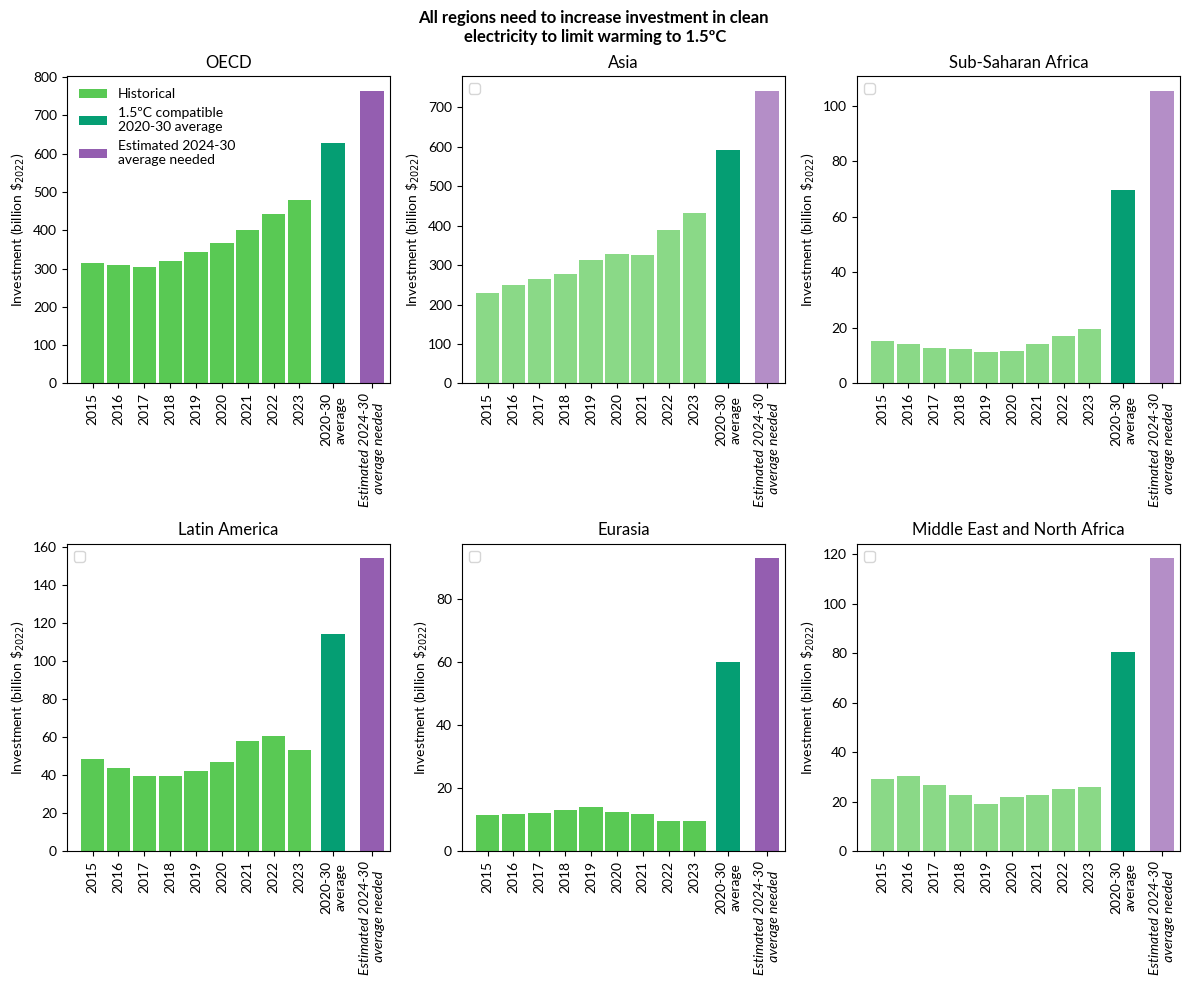

In [97]:
f, axes = plt.subplots(nrows=2,ncols=3,figsize=(12,10),sharey=False)

plot_regions = inv_benchmarks.index[:-1]

for count, ax in enumerate(axes.ravel()):
    inv_hist.loc[isin(
        variable='Renewables and Grids',
        region=plot_regions[count]),2015:2023].T.plot(
        kind='bar',width=0.9,ax=ax,color=ca_colors[5],)

    ax.bar(x=9.3,
       height=inv_benchmarks.loc[plot_regions[count],inv('Renewables and Grids')]/10,
       color=ca_colors[6],
       width=0.9
      )
    
    ax.bar(x=10.8,
           height=inv_benchmarks_rescaled.loc[plot_regions[count],inv('Renewables and Grids')]/6,
           color=ca_colors[7],
           width=0.9
          )
        
    ax.set_xlim([-1,11.5])
    ax.set_title(plot_regions[count])
    ax.set_ylabel('Investment (billion \$$_{2022}$)')
    ax.legend([])

    ax.set_xticks(
        list(range(9))+[9.3,10.8],
        list(range(2015,2024))+['2020-30\naverage','Estimated 2024-30\n average needed'],
        rotation=90)
        
    # ax.get_xticklabels()[-2].set_fontweight('bold') 
    # ax.get_xticklabels()[-2].set_fontsize(10)
    # ax.get_xticklabels()[-1].set_fontweight('bold') 
    # ax.get_xticklabels()[-2].set_rotation(0)
    ax.get_xticklabels()[-1].set_style('italic') 
    # ax.get_xticklabels()[-1].set_rotation(0)
    # ax.get_xticklabels()[-1].set_fontsize(10) 


for ax in axes.ravel()[[1,2,5]]:
    for bar in range(9):
        # ax.containers[0][bar].set_edgecolor(ca_colors[6])
        # ax.containers[0][bar].set_linestyle('--')
        ax.containers[0][bar].set_alpha(0.7)
    
    ax.containers[2][0].set_alpha(0.7)


axes[0,0].legend(['Historical','1.5ºC compatible\n2020-30 average','Estimated 2024-30\naverage needed'],
          edgecolor='w')
f.suptitle('All regions need to increase investment in clean \nelectricity to limit warming to 1.5ºC',
           fontweight='bold')
plt.tight_layout()

plt.savefig('../outputs/figures/regional_investment_gap.png',dpi=300,bbox_inches='tight')

## Per-capita investments

In [98]:
ar6_data.filter(variable='*per_capita',keep=False,inplace=True)
ar6_data.convert_unit('EJ/yr','TWh / yr',inplace=True)
ar6_data.divide(
    elec(),
    'Population',
    elec()+'|per_capita',
    ignore_units = 'MWh / person',
    append=True)

for sector in ['Industry','Transportation','Residential and Commercial']:
    ar6_data.divide(
        f'Final Energy|{sector}',
        'Population',
        f'Final Energy|{sector}|per_capita',
        ignore_units = 'MWh / person',
        append=True)
    
for variable in ['Renewables','Transmission, Distribution and Storage','Other']:
    ar6_data.divide(
        inv(variable),
        'Population',
        inv(variable)+'|per_capita',
        ignore_units = '10^3 USD_2022 / person',
        append=True)

ar6_data.convert_unit('10^3 USD_2022 / person','USD_2022 / person',factor=1e3,inplace=True)

In [99]:
per_capita_2030 = ar6_data.filter(
    pathway=filter_set_24,
    variable='*per_capita',
    year=2030,
    region=regions).timeseries().groupby(['region','variable','unit']).median().unstack('region')

per_capita_2030 = per_capita_2030.T.droplevel(level=0).T
per_capita_2030
# per_capita['R5OECD']/per_capita['R10AFRICA']

region                                                                R10AFRICA  \
variable                                           unit                           
Final Energy|Industry|per_capita                   MWh / person            1.21   
Final Energy|Residential and Commercial|per_capita MWh / person            2.82   
Final Energy|Transportation|per_capita             MWh / person            0.87   
Investment|Energy Supply|Electricity|Other|per_... USD_2022 / person       0.00   
Investment|Energy Supply|Electricity|Renewables... USD_2022 / person      64.33   
Investment|Energy Supply|Electricity|Transmissi... USD_2022 / person      60.32   
Secondary Energy|Electricity|per_capita            MWh / person            0.86   

region                                                                R10LATIN_AM  \
variable                                           unit                             
Final Energy|Industry|per_capita                   MWh / person              2.87   
Final Energy|Residential and Commercial|per_capita MWh / person              2.78   
Final Energy|Transportation|per_capita             MWh / person              3.62   
Investment|Energy Supply|Electricity|Other|per_... USD_2022 / person         0.00   
Investment|Energy Supply|Electricity|Renewables... USD_2022 / person       150.57   
Investment|Energy Supply|Electricity|Transmissi... USD_2022 / person       187.17   
Secondary Energy|Electricity|per_capita            MWh / person              3.62   

region                                                                R10MIDDLE_EAST  \
variable                                           unit                                
Final Energy|Industry|per_capita                   MWh / person                 3.53   
Final Energy|Residential and Commercial|per_capita MWh / person                 3.94   
Final Energy|Transportation|per_capita             MWh / person                 4.26   
Investment|Energy Supply|Electricity|Other|per_... USD_2022 / person            0.00   
Investment|Energy Supply|Electricity|Renewables... USD_2022 / person          179.29   
Investment|Energy Supply|Electricity|Transmissi... USD_2022 / person          227.78   
Secondary Energy|Electricity|per_capita            MWh / person                 3.82   

region                                                                R10REF_ECON  \
variable                                           unit                             
Final Energy|Industry|per_capita                   MWh / person              5.39   
Final Energy|Residential and Commercial|per_capita MWh / person              6.99   
Final Energy|Transportation|per_capita             MWh / person              3.87   
Investment|Energy Supply|Electricity|Other|per_... USD_2022 / person         0.00   
Investment|Energy Supply|Electricity|Renewables... USD_2022 / person       284.57   
Investment|Energy Supply|Electricity|Transmissi... USD_2022 / person       171.19   
Secondary Energy|Electricity|per_capita            MWh / person              5.53   

region                                                                R5ASIA  \
variable                                           unit                        
Final Energy|Industry|per_capita                   MWh / person         3.85   
Final Energy|Residential and Commercial|per_capita MWh / person         3.02   
Final Energy|Transportation|per_capita             MWh / person         2.36   
Investment|Energy Supply|Electricity|Other|per_... USD_2022 / person    0.00   
Investment|Energy Supply|Electricity|Renewables... USD_2022 / person  180.22   
Investment|Energy Supply|Electricity|Transmissi... USD_2022 / person  190.19   
Secondary Energy|Electricity|per_capita            MWh / person         3.88   

region                                                                R5OECD  
variable                                           unit                       
Final Energy|Industry|per_capita                

In [100]:
per_capita_2050 = ar6_data.filter(
    pathway=filter_set_24,
    variable='*per_capita',
    year=2100,
    region=regions).timeseries().groupby(['region','variable','unit']).median().unstack('region')

per_capita_2050 = per_capita_2050.T.droplevel(level=0).T
per_capita_2050
# per_capita['R5OECD']/per_capita['R10AFRICA']

region                                                                R10AFRICA  \
variable                                           unit                           
Final Energy|Industry|per_capita                   MWh / person            4.04   
Final Energy|Residential and Commercial|per_capita MWh / person            4.33   
Final Energy|Transportation|per_capita             MWh / person            1.90   
Investment|Energy Supply|Electricity|Other|per_... USD_2022 / person       0.00   
Investment|Energy Supply|Electricity|Renewables... USD_2022 / person     285.87   
Investment|Energy Supply|Electricity|Transmissi... USD_2022 / person     427.25   
Secondary Energy|Electricity|per_capita            MWh / person           10.09   

region                                                                R10LATIN_AM  \
variable                                           unit                             
Final Energy|Industry|per_capita                   MWh / person              5.30   
Final Energy|Residential and Commercial|per_capita MWh / person              6.98   
Final Energy|Transportation|per_capita             MWh / person              3.34   
Investment|Energy Supply|Electricity|Other|per_... USD_2022 / person         0.00   
Investment|Energy Supply|Electricity|Renewables... USD_2022 / person       213.70   
Investment|Energy Supply|Electricity|Transmissi... USD_2022 / person       425.91   
Secondary Energy|Electricity|per_capita            MWh / person             15.05   

region                                                                R10MIDDLE_EAST  \
variable                                           unit                                
Final Energy|Industry|per_capita                   MWh / person                 5.12   
Final Energy|Residential and Commercial|per_capita MWh / person                 8.61   
Final Energy|Transportation|per_capita             MWh / person                 3.26   
Investment|Energy Supply|Electricity|Other|per_... USD_2022 / person            0.00   
Investment|Energy Supply|Electricity|Renewables... USD_2022 / person          278.41   
Investment|Energy Supply|Electricity|Transmissi... USD_2022 / person          484.36   
Secondary Energy|Electricity|per_capita            MWh / person                18.16   

region                                                                R10REF_ECON  \
variable                                           unit                             
Final Energy|Industry|per_capita                   MWh / person              7.95   
Final Energy|Residential and Commercial|per_capita MWh / person              7.41   
Final Energy|Transportation|per_capita             MWh / person              4.78   
Investment|Energy Supply|Electricity|Other|per_... USD_2022 / person         0.00   
Investment|Energy Supply|Electricity|Renewables... USD_2022 / person       392.09   
Investment|Energy Supply|Electricity|Transmissi... USD_2022 / person       303.86   
Secondary Energy|Electricity|per_capita            MWh / person             19.77   

region                                                                R5ASIA  \
variable                                           unit                        
Final Energy|Industry|per_capita                   MWh / person         5.15   
Final Energy|Residential and Commercial|per_capita MWh / person         5.53   
Final Energy|Transportation|per_capita             MWh / person         2.53   
Investment|Energy Supply|Electricity|Other|per_... USD_2022 / person    0.00   
Investment|Energy Supply|Electricity|Renewables... USD_2022 / person  257.25   
Investment|Energy Supply|Electricity|Transmissi... USD_2022 / person  378.13   
Secondary Energy|Electricity|per_capita            MWh / person        11.59   

region                                                                R5OECD  
variable                                           unit                       
Final Energy|Industry|per_capita                

In [101]:
per_capita_2050.loc[ismatch(variable='Fin**')].sum()

region
R10AFRICA         10.27
R10LATIN_AM       15.62
R10MIDDLE_EAST    16.99
R10REF_ECON       20.14
R5ASIA            13.20
R5OECD            22.53
dtype: float64

In [102]:


per_capita_elec = (ar6_data.filter(
    pathway=filter_set_24,
    variable=elec('per_capita'),
    year=[2020,2030],
    region=regions)
 .timeseries())

elec_growth = pd.concat([
    per_capita_elec[2020].groupby(['region','variable']).median(),
    per_capita_elec[2030].groupby(['region','variable']).median(),
    (per_capita_elec[2030]/per_capita_elec[2020]
    ).groupby(['region','variable']).median(),
    (per_capita_elec[2030]-per_capita_elec[2020]
    ).groupby(['region','variable']).median()
],
         axis=1)

elec_growth.columns = [
    '2020 per capita electricity demand (MWh / person)',
    '2030 per capita electricity demand (MWh / person)',
    '2020–30 growth in per capita electricity demand (relative)',
    '2020–30 growth in per capita electricity demand (absolute MWh/person)']

elec_growth

2020 per capita electricity demand (MWh / person)  \
region         variable                                                                                     
R10AFRICA      Secondary Energy|Electricity|per_capita                                               0.52   
R10LATIN_AM    Secondary Energy|Electricity|per_capita                                               2.74   
R10MIDDLE_EAST Secondary Energy|Electricity|per_capita                                               3.45   
R10REF_ECON    Secondary Energy|Electricity|per_capita                                               5.62   
R5ASIA         Secondary Energy|Electricity|per_capita                                               2.83   
R5OECD         Secondary Energy|Electricity|per_capita                                               9.11   

                                                        2030 per capita electricity demand (MWh / person)  \
region         variable                                                                                     
R10AFRICA      Secondary Energy|Electricity|per_capita                                               0.86   
R10LATIN_AM    Secondary Energy|Electricity|per_capita                                               3.62   
R10MIDDLE_EAST Secondary Energy|Electricity|per_capita                                               3.82   
R10REF_ECON    Secondary Energy|Electricity|per_capita                                               5.53   
R5ASIA         Secondary Energy|Electricity|per_capita                                               3.88   
R5OECD         Secondary Energy|Electricity|per_capita                                               9.50   

                                                        2020–30 growth in per capita electricity demand (relative)  \
region         variable                                                                                              
R10AFRICA      Secondary Energy|Electricity|per_capita                                               1.76            
R10LATIN_AM    Secondary Energy|Electricity|per_capita                                               1.31            
R10MIDDLE_EAST Secondary Energy|Electricity|per_capita                                               1.12            
R10REF_ECON    Secondary Energy|Electricity|per_capita                                               1.01            
R5ASIA         Secondary Energy|Electricity|per_capita                                               1.38            
R5OECD         Secondary Energy|Electricity|per_capita                                               1.04            

                                                        2020–30 growth in per capita electricity demand (absolute MWh/person)  
region         variable                                                                                                        
R10AFRICA      Secondary Energy|Electricity|per_capita                                               0.37                      
R10LATIN_AM    Secondary Energy|Electricity|per_capita                                               0.85                      
R10MIDDLE_EAST Secondary Energy|Electricity|per_capita                                               0.40                      
R10REF_ECON    Secondary Energy|Electricity|per_capita                                               0.03                      
R5ASIA         Secondary Energy|Electricity|per_capita                                               1.07                      
R5OECD         Secondary Energy|Electricity|per_capita                                               0.40

# Output data

In [103]:
dt.findp(source='IEA_WEB**2023',variable='Final Energy|Industry**')

variable  \
Final Energy|Industry|Hard coal__Historic__IEA_...                  Final Energy|Industry|Hard coal   
Final Energy|Industry|Brown coal__Historic__IEA...                 Final Energy|Industry|Brown coal   
Final Energy|Industry|Anthracite__Historic__IEA...                 Final Energy|Industry|Anthracite   
Final Energy|Industry|Coking coal__Historic__IE...                Final Energy|Industry|Coking coal   
Final Energy|Industry|Other bituminous coal__Hi...      Final Energy|Industry|Other bituminous coal   
...                                                                                             ...   
Final Energy|Industry|Coal, peat and oil shale_...   Final Energy|Industry|Coal, peat and oil shale   
Final Energy|Industry|Primary and secondary oil...  Final Energy|Industry|Primary and secondary oil   
Final Energy|Industry|Biofuels and waste__Histo...         Final Energy|Industry|Biofuels and waste   
Final Energy|Industry|Other renewables__Histori...           Final Energy|Industry|Other renewables   
Final Energy|Industry|Solar/wind/other__Histori...           Final Energy|Industry|Solar/wind/other   

                                                                   entity  \
Final Energy|Industry|Hard coal__Historic__IEA_...  Final Energy|Industry   
Final Energy|Industry|Brown coal__Historic__IEA...  Final Energy|Industry   
Final Energy|Industry|Anthracite__Historic__IEA...  Final Energy|Industry   
Final Energy|Industry|Coking coal__Historic__IE...  Final Energy|Industry   
Final Energy|Industry|Other bituminous coal__Hi...  Final Energy|Industry   
...                                                                   ...   
Final Energy|Industry|Coal, peat and oil shale_...  Final Energy|Industry   
Final Energy|Industry|Primary and secondary oil...  Final Energy|Industry   
Final Energy|Industry|Biofuels and waste__Histo...  Final Energy|Industry   
Final Energy|Industry|Other renewables__Histori...  Final Energy|Industry   
Final Energy|Industry|Solar/wind/other__Histori...  Final Energy|Industry   

                                                                     category  \
Final Energy|Industry|Hard coal__Historic__IEA_...                  Hard coal   
Final Energy|Industry|Brown coal__Historic__IEA...                 Brown coal   
Final Energy|Industry|Anthracite__Historic__IEA...                 Anthracite   
Final Energy|Industry|Coking coal__Historic__IE...                Coking coal   
Final Energy|Industry|Other bituminous coal__Hi...      Other bituminous coal   
...                                                                       ...   
Final Energy|Industry|Coal, peat and oil shale_...   Coal, peat and oil shale   
Final Energy|Industry|Primary and secondary oil...  Primary and secondary oil   
Final Energy|Industry|Biofuels and waste__Histo...         Biofuels and waste   
Final Energy|Industry|Other renewables__Histori...           Other renewables   
Final Energy|Industry|Solar/wind/other__Histori...           Solar/wind/other   

                                                     pathway  scenario model  \
Final Energy|Industry|Hard coal__Historic__IEA_...  Historic  Historic   NaN   
Final Energy|Industry|Brown coal__Historic__IEA...  Historic  Historic   NaN   
Final Energy|Industry|Anthracite__Historic__IEA...  Historic  Historic   NaN   
Final Energy|Industry|Coking coal__Historic__IE...  Historic  Historic   NaN   
Final Energy|Industry|Other bituminous coal__Hi...  Historic  Historic   NaN   
...                                                      ...       ...   ...   
Final Energy|Industry|Coal, peat and oil shale_...  Historic  Historic   NaN   
Final Energy|Industry|Primary and secondary oil...  Historic  Historic   NaN   
Final Energy|Industry|Biofuels and waste__Histo...  Historic  Historic   NaN   
Final Energy|Industry|Other renewables__Histori...  Historic  Historic   NaN   
Final Energy|Industry|Solar/wind/other__Histori...  Historic  Historic   NaN

In [104]:
writer = pd.ExcelWriter(
    '../outputs/data/output_data.xlsx')

In [110]:
cap_data = (
    cap_hist.loc[isin(region=regions,variable=[cap('Renewables'),cap('WnS')])]
    .merge(
        pd.concat([rnw_cap_1o5.loc[isin(scenario='central')].droplevel('scenario'),
                   wns_cap_1o5]).loc[:,2024:],
        on=['region','variable','unit'])
)

cap_data = assignlevel(
    cap_data,
    region = projectlevel(cap_data,'region')
            .rename(index=lambda s:dict(zip(regions,region_names))[s]).index
)

cap_data.to_excel(writer,sheet_name='capacity_data')

In [111]:
inv_data = inv_benchmarks_rescaled.rename(index=lambda s:s.replace('\n',''))
inv_data = inv_data[
    [inv('Renewables and Grids'),inv('Renewables'),inv('Transmission, Distribution and Storage')]
]

inv_data = assignlevel(inv_data,
           variable='Investment required until 2030',
            unit='billion USD2022')

inv_data.columns.name = None

inv_data.to_excel(writer,sheet_name='investment_data')

In [112]:
writer.close()